# Classification: Clustering to Find Economic States

- The **goal** is to empirically determine (sift through) the most valuable features for a classification model that determines economic states, then validate the feature set through theory, logic, and reasoning

# To Do
- Find optimal feature combination and model
- Family wise error rate for feature/model selection (reduce overfitting/fitting to noise)
- Cross validation

In [244]:
import heapq
import itertools
import numpy as np
import pandas as pd
import pickle
from collections import Counter
from utils import *
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler

In [245]:
# Load in data

fd_cs_df = pd.read_csv("/Users/henrycosentino/Desktop/Python/Projects/State Dependent CVaR & VaR/data/fd_cubic_processed.csv")
fd_lin_df = pd.read_csv("/Users/henrycosentino/Desktop/Python/Projects/State Dependent CVaR & VaR/data/fd_linear_processed.csv")
rd_cs_df = pd.read_csv("/Users/henrycosentino/Desktop/Python/Projects/State Dependent CVaR & VaR/data/rd_cubic_processed.csv")
rd_lin_df = pd.read_csv("/Users/henrycosentino/Desktop/Python/Projects/State Dependent CVaR & VaR/data/rd_linear_processed.csv")


fd_cs_df = fd_cs_df.set_index('date')
fd_lin_df = fd_lin_df.set_index('date')
rd_cs_df = rd_cs_df.set_index('date')
rd_lin_df = rd_lin_df.set_index('date')

df_dict = {
    "fd_cubic": fd_cs_df,
    "fd_linear": fd_lin_df,
    "rd_cubic": rd_cs_df,
    "rd_linear": rd_lin_df
}   

In [246]:
# Non-combination analysis

numeric_cols = [
    'PCE SA', 'CPI SA', 'U6 SA', 'U3 SA',
    'Initial Claims SA', 'Number Unemployed SA',
    'Job Openings SA'
]

fd_cs_heap = []
fd_lin_heap = []
rd_cs_heap = []
rd_lin_heap = []

for k in range(3, 8):
    print(f"Working on k={k}")
    try:
        scaler_fd_cs = StandardScaler()
        scaler_fd_lin = StandardScaler()
        scaler_rd_cs = StandardScaler()
        scaler_rd_lin = StandardScaler()
                
        fd_cs_features_scaled = scaler_fd_cs.fit_transform(fd_cs_df[numeric_cols])
        fd_lin_features_scaled = scaler_fd_lin.fit_transform(fd_lin_df[numeric_cols])
        rd_cs_features_scaled = scaler_rd_cs.fit_transform(rd_cs_df[numeric_cols])
        rd_lin_features_scaled = scaler_rd_lin.fit_transform(rd_lin_df[numeric_cols])
                
        if (len(fd_cs_features_scaled) < k or len(fd_lin_features_scaled) < k or 
            len(rd_cs_features_scaled) < k or len(rd_lin_features_scaled) < k):
            continue
                
        kmeans_fd_cs = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        kmeans_fd_lin = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        kmeans_rd_cs = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
        kmeans_rd_lin = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
                
        fd_cs_labels = kmeans_fd_cs.fit_predict(fd_cs_features_scaled)
        fd_lin_labels = kmeans_fd_lin.fit_predict(fd_lin_features_scaled)
        rd_cs_labels = kmeans_rd_cs.fit_predict(rd_cs_features_scaled)
        rd_lin_labels = kmeans_rd_lin.fit_predict(rd_lin_features_scaled)
                
        fd_cs_silhouette = silhouette_score(fd_cs_features_scaled, fd_cs_labels)
        fd_lin_silhouette = silhouette_score(fd_lin_features_scaled, fd_lin_labels)
        rd_cs_silhouette = silhouette_score(rd_cs_features_scaled, rd_cs_labels)
        rd_lin_silhouette = silhouette_score(rd_lin_features_scaled, rd_lin_labels)
                
        # Negative for max heap like structure
        heapq.heappush(fd_cs_heap, (-fd_cs_silhouette, k))
        heapq.heappush(fd_lin_heap, (-fd_lin_silhouette, k))
        heapq.heappush(rd_cs_heap, (-rd_cs_silhouette, k))
        heapq.heappush(rd_lin_heap, (-rd_lin_silhouette, k))
                
    except Exception as e:
        continue

Working on k=3
Working on k=4
Working on k=5
Working on k=6
Working on k=7


In [247]:
# Display best model scores

print("Max score for FD Cubic: ", heapq.heappop(fd_cs_heap))
print("Max score for FD Linear: ", heapq.heappop(fd_lin_heap))
print("Max score for RD Cubic: ", heapq.heappop(rd_cs_heap))
print("Max score for RD Linear: ", heapq.heappop(rd_lin_heap))

Max score for FD Cubic:  (-0.9191046142535779, 3)
Max score for FD Linear:  (-0.9276477195698632, 3)
Max score for RD Cubic:  (-0.9579749763322871, 3)
Max score for RD Linear:  (-0.9560487964797119, 3)


In [ ]:
# Find optimal combination of economic features for data frames

numeric_cols = [
    'WTI', 'CBOE VIX', 'PCE SA', 'CPI SA', 'U6 SA', 'U3 SA',
    '5YR Breakeven Inflation', '10YR Breakeven Inflation',
    'Treasury 10YR minus 2YR', 'Treasury 10YR minus 3M', 'HY OAS',
    'Initial Claims SA', 'Number Unemployed SA', 'Job Openings SA'
]

fd_cs_heap = []
fd_lin_heap = []
rd_cs_heap = []
rd_lin_heap = []

total_combinations = sum(len(list(itertools.combinations(numeric_cols, i))) for i in range(2, 5))
processed = 0

print(f"Processing {total_combinations} feature combinations...")

for i in range(2, 5):
    print(f"Testing combinations of {i} features...")
    
    for col_combo in itertools.combinations(numeric_cols, i):
        processed += 1
        print(f"Working on combination {processed}")
        
        for k in range(3, 6):
            try:
                scaler_fd_cs = StandardScaler()
                scaler_fd_lin = StandardScaler()
                scaler_rd_cs = StandardScaler()
                scaler_rd_lin = StandardScaler()
                
                fd_cs_features_scaled = scaler_fd_cs.fit_transform(fd_cs_df[list(col_combo)].dropna())
                fd_lin_features_scaled = scaler_fd_lin.fit_transform(fd_lin_df[list(col_combo)].dropna())
                rd_cs_features_scaled = scaler_rd_cs.fit_transform(rd_cs_df[list(col_combo)].dropna())
                rd_lin_features_scaled = scaler_rd_lin.fit_transform(rd_lin_df[list(col_combo)].dropna())
                
                if (len(fd_cs_features_scaled) < k or len(fd_lin_features_scaled) < k or 
                    len(rd_cs_features_scaled) < k or len(rd_lin_features_scaled) < k):
                    continue
                
                kmeans_fd_cs = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
                kmeans_fd_lin = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
                kmeans_rd_cs = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
                kmeans_rd_lin = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
                
                fd_cs_labels = kmeans_fd_cs.fit_predict(fd_cs_features_scaled)
                fd_lin_labels = kmeans_fd_lin.fit_predict(fd_lin_features_scaled)
                rd_cs_labels = kmeans_rd_cs.fit_predict(rd_cs_features_scaled)
                rd_lin_labels = kmeans_rd_lin.fit_predict(rd_lin_features_scaled)
                
                fd_cs_silhouette = silhouette_score(fd_cs_features_scaled, fd_cs_labels)
                fd_lin_silhouette = silhouette_score(fd_lin_features_scaled, fd_lin_labels)
                rd_cs_silhouette = silhouette_score(rd_cs_features_scaled, rd_cs_labels)
                rd_lin_silhouette = silhouette_score(rd_lin_features_scaled, rd_lin_labels)
                
                 # Negative for max heap like structure
                heapq.heappush(fd_cs_heap, (-fd_cs_silhouette, col_combo, k, len(col_combo)))
                heapq.heappush(fd_lin_heap, (-fd_lin_silhouette, col_combo, k, len(col_combo)))
                heapq.heappush(rd_cs_heap, (-rd_cs_silhouette, col_combo, k, len(col_combo)))
                heapq.heappush(rd_lin_heap, (-rd_lin_silhouette, col_combo, k, len(col_combo)))
                
            except Exception as e:
                continue

In [ ]:
# Downloading maxheaps (maxheaps are downloaded because, the prior cell takes a long-time to run)

import pickle

maxheap_dict = {
    "fd_cubic": fd_cs_heap,
    "fd_linear": fd_lin_heap,
    "rd_cubic": rd_cs_heap,
    "rd_linear": rd_lin_heap
}

base_path = "/Users/henrycosentino/Desktop/Python/Projects/State Dependent CVaR & VaR/data"

for key, heap in maxheap_dict.items():
    try:
        filename = f"{base_path}/{key}_maxheap_(2-4_feature_combos).pkl"
        with open(filename, 'wb') as f:
            pickle.dump(heap, f)
    except Exception as e:
        print(f"Error saving {key}: {e}")

In [250]:
# Load in the (above downloaded) data

maxheaps_dict = {}

base_path = "/Users/henrycosentino/Desktop/Python/Projects/State Dependent CVaR & VaR/data"
heap_keys = ["fd_cubic", "fd_linear", "rd_cubic", "rd_linear"]

for key in heap_keys:
    filename = f"{base_path}/{key}_maxheap_(2-4_feature_combos).pkl"
    with open(filename, 'rb') as f:
        maxheaps_dict[key] = pickle.load(f)

In [251]:
# Display top 5 combos for each data set

for key in heap_keys:
    heap = maxheaps_dict[key]
    print("----"*20)
    print(f"Top five combos for {key}")

    for i in range(1, 5):
        combo_stats = heapq.heappop(heap)
        combo = combo_stats[1]
        score = -round(combo_stats[0], 4)

        print(f"#{i}: \n  Combo: {combo}\n  Score: {score}")

--------------------------------------------------------------------------------
Top five combos for fd_cubic
#1: 
  Combo: ('U3 SA', 'Number Unemployed SA')
  Score: 0.9766
#2: 
  Combo: ('U6 SA', 'U3 SA', 'Number Unemployed SA')
  Score: 0.974
#3: 
  Combo: ('U6 SA', 'U3 SA')
  Score: 0.9738
#4: 
  Combo: ('U6 SA', 'Number Unemployed SA')
  Score: 0.9736
--------------------------------------------------------------------------------
Top five combos for fd_linear
#1: 
  Combo: ('U3 SA', 'Number Unemployed SA')
  Score: 0.9807
#2: 
  Combo: ('U6 SA', 'U3 SA', 'Number Unemployed SA')
  Score: 0.9788
#3: 
  Combo: ('U6 SA', 'U3 SA')
  Score: 0.9778
#4: 
  Combo: ('U6 SA', 'Number Unemployed SA')
  Score: 0.9776
--------------------------------------------------------------------------------
Top five combos for rd_cubic
#1: 
  Combo: ('U3 SA', 'Number Unemployed SA')
  Score: 0.9766
#2: 
  Combo: ('U6 SA', 'U3 SA', 'Number Unemployed SA')
  Score: 0.974
#3: 
  Combo: ('U6 SA', 'U3 SA')
 

In [252]:
# Analyze all combinations of 2, 3, & 4 features

num_bins = 10

all_model_stats_percentile_dict = {}
for heap_key in heap_keys:
    model_stats_ls = list(maxheaps_dict[heap_key])
    model_stats_ls.sort(key=lambda x: x[0])
    model_stats_arr = np.array(model_stats_ls, dtype=object)
    model_stats_binned = np.array_split(model_stats_arr, num_bins)

    model_stats_percentile_dict = {}
    for i in range(num_bins):
        bin_i = model_stats_binned[i]

        cum_score_i = 0
        features_i = []
        k_i = []
        for combo_i in bin_i:
            cum_score_i += -float(combo_i[0])
            features_i += list(combo_i[1])
            k_i.append(int(combo_i[2]))

        score_i_avg = cum_score_i / len(bin_i)
        features_i_count = Counter(features_i)
        k_i_count = Counter(k_i)

        model_stats_percentile_dict[i] = {
            "score_avg": score_i_avg,
            "features_count": features_i_count,
            "n_clusters_count": k_i_count,
            }
    
    all_model_stats_percentile_dict[heap_key] = model_stats_percentile_dict

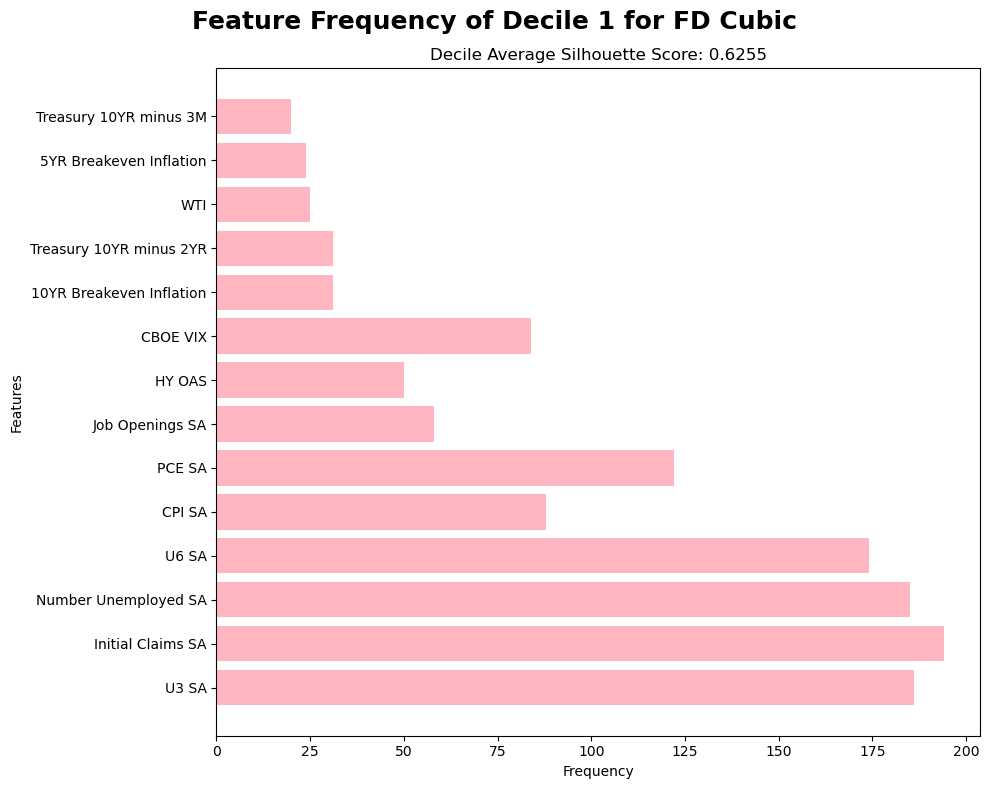

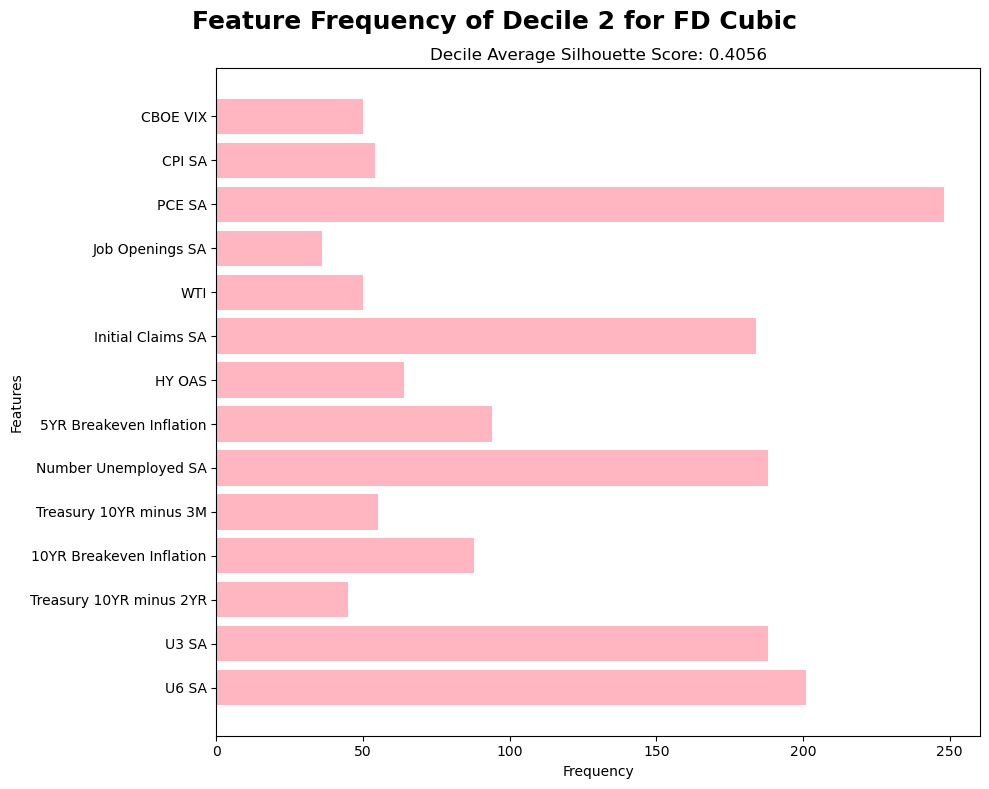

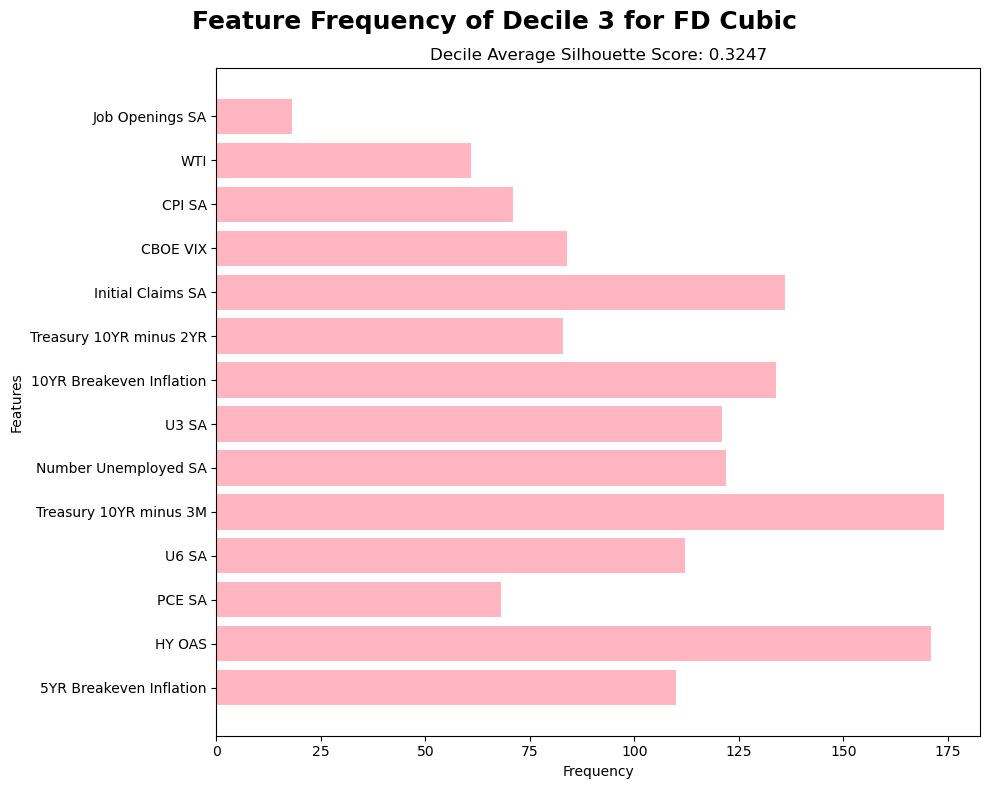

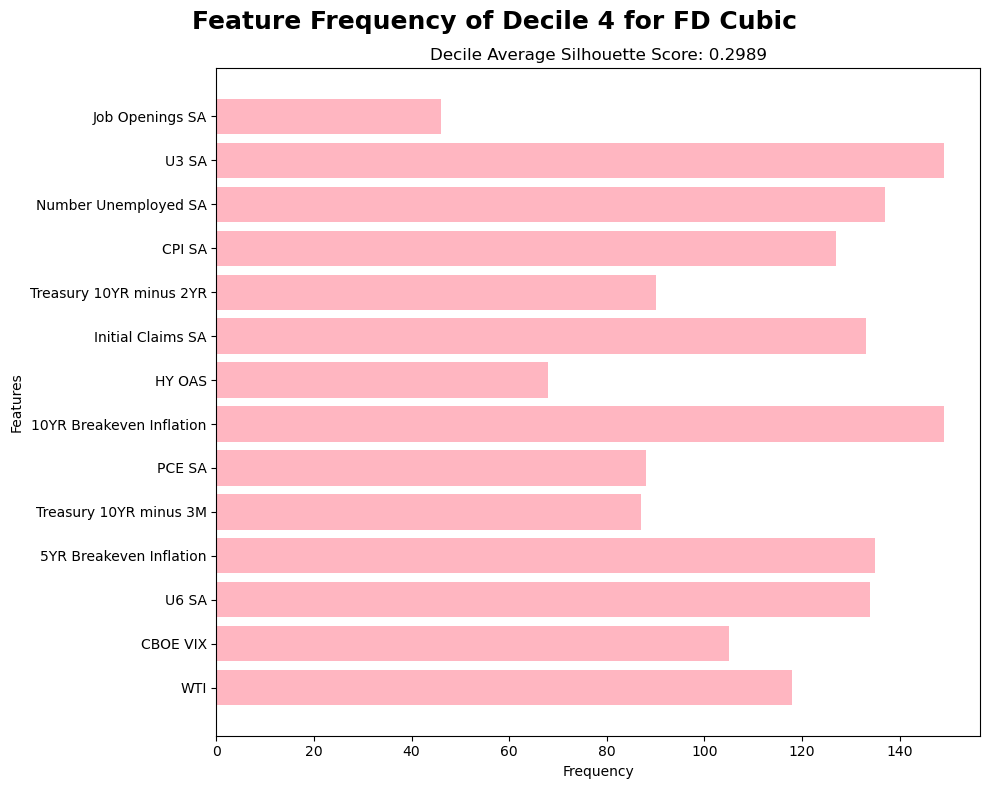

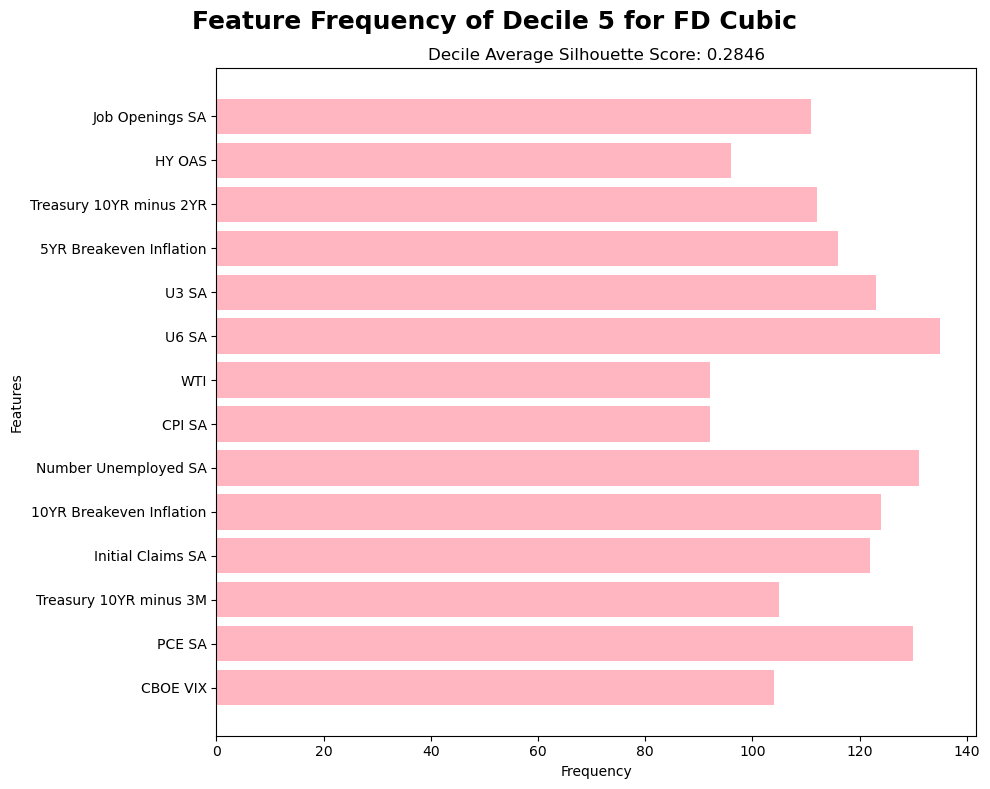

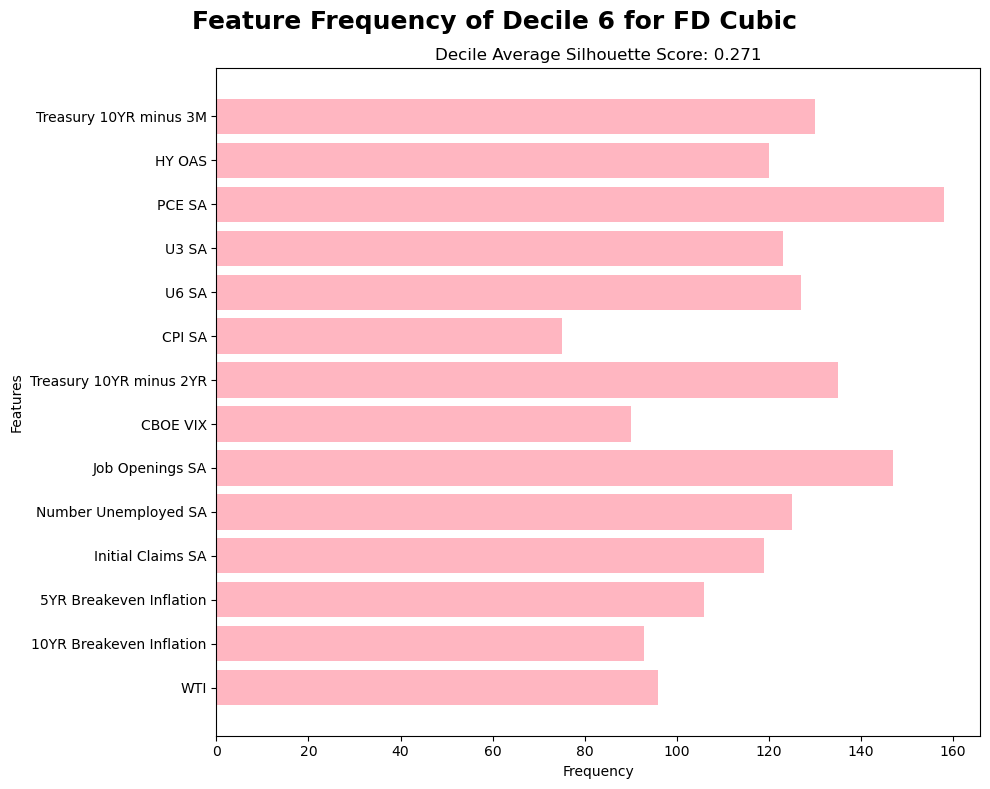

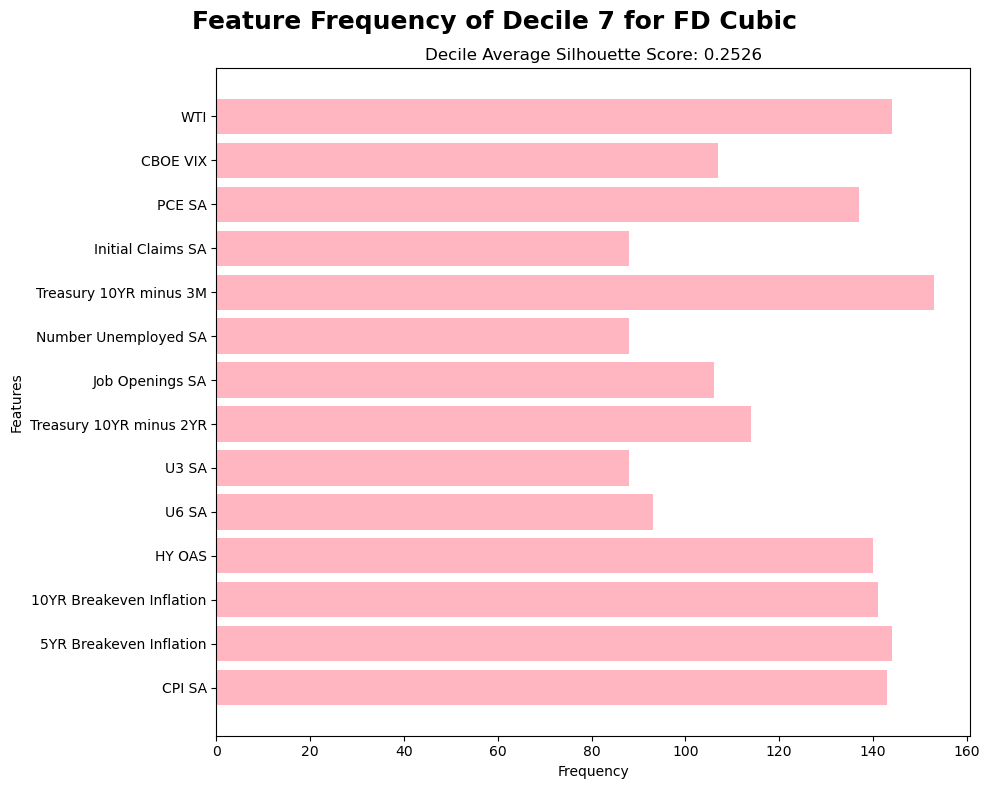

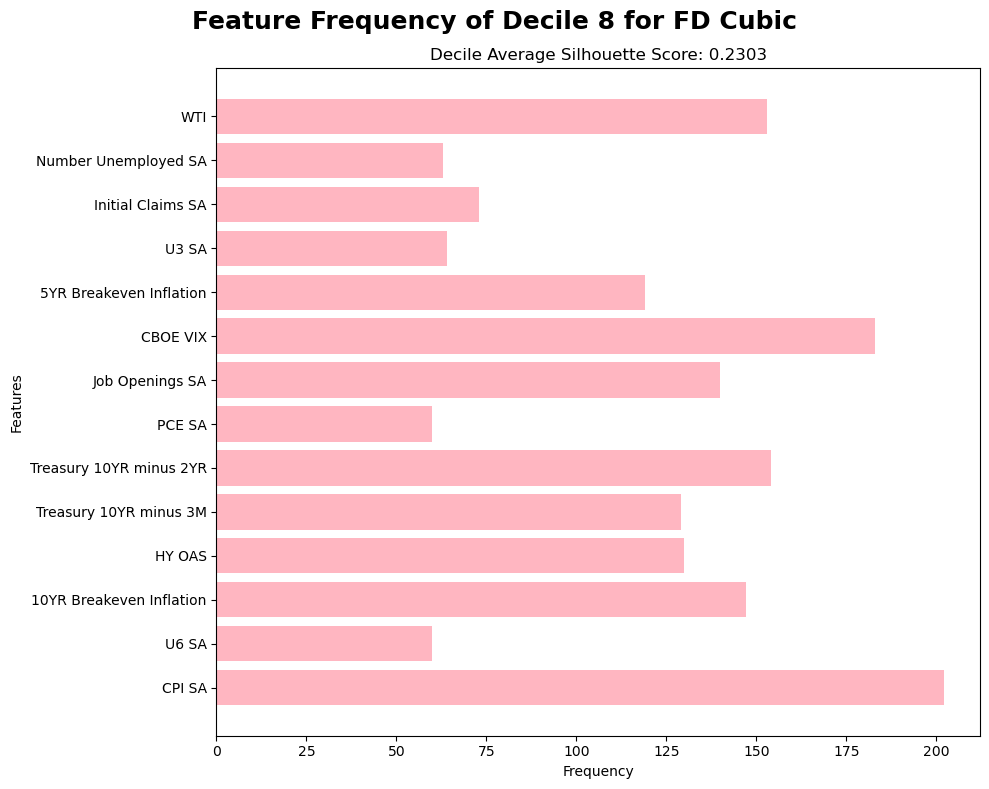

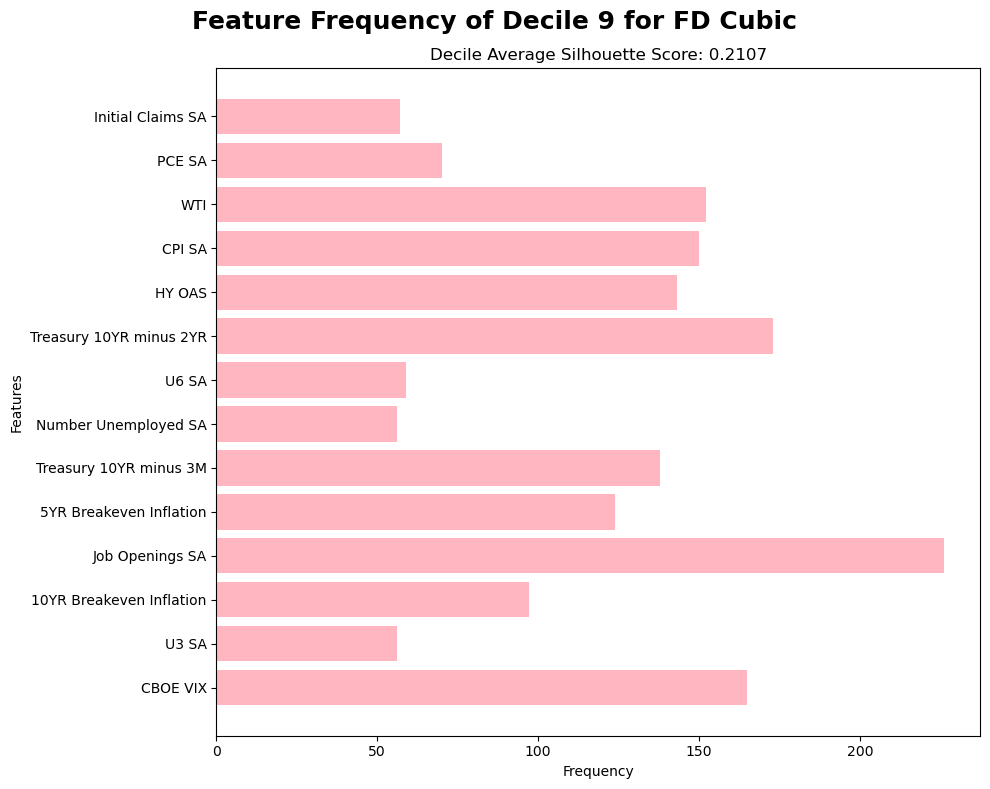

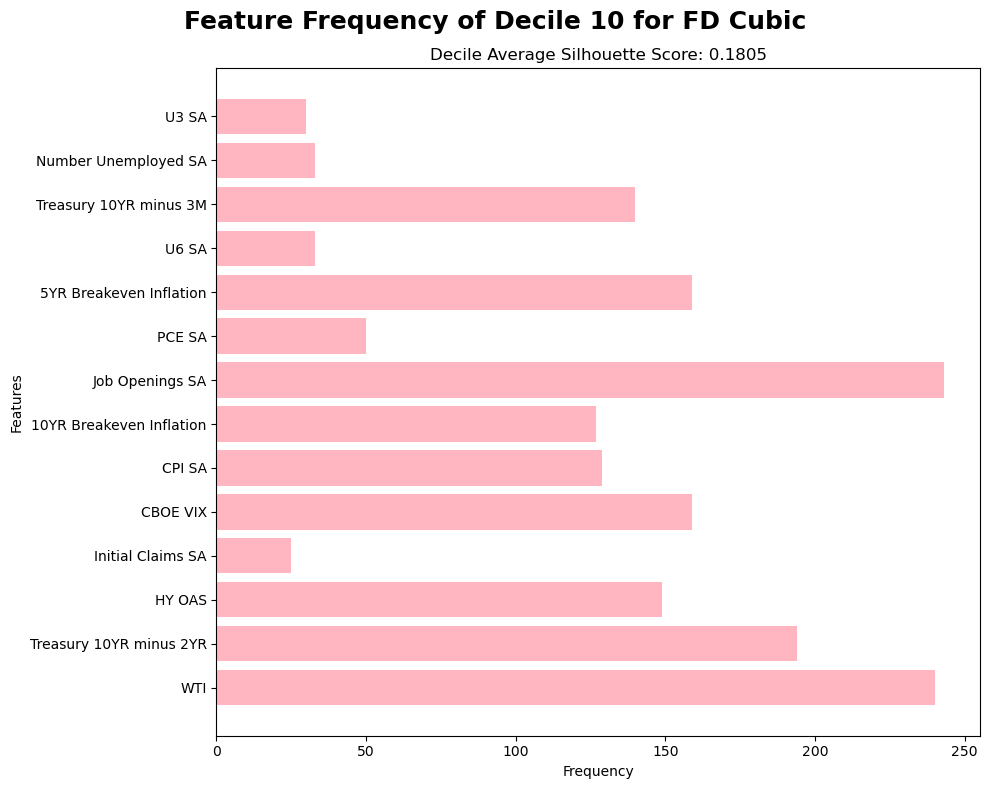

In [253]:
# Fractionally Differenced Cubic Imputed Data

fd_cubic_stats_dict = all_model_stats_percentile_dict['fd_cubic']

for decile_key, stats_dict in fd_cubic_stats_dict.items():
    decile_num = int(decile_key) + 1
    plot_feature_frequency(decile_num, stats_dict, "FD Cubic")

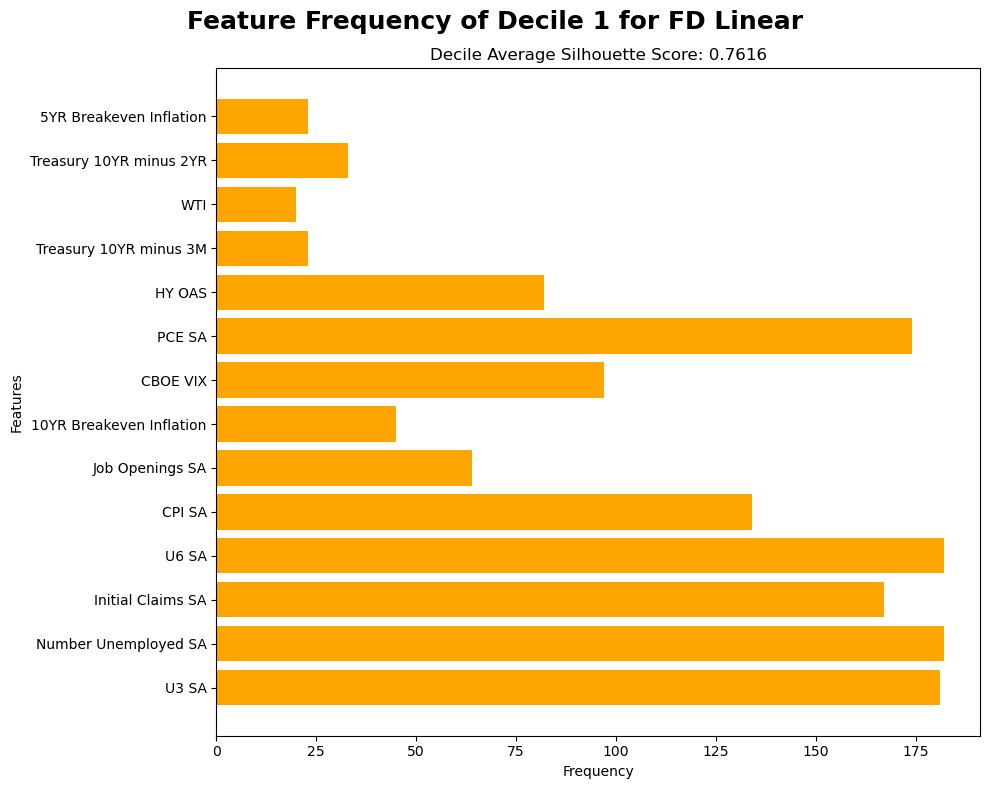

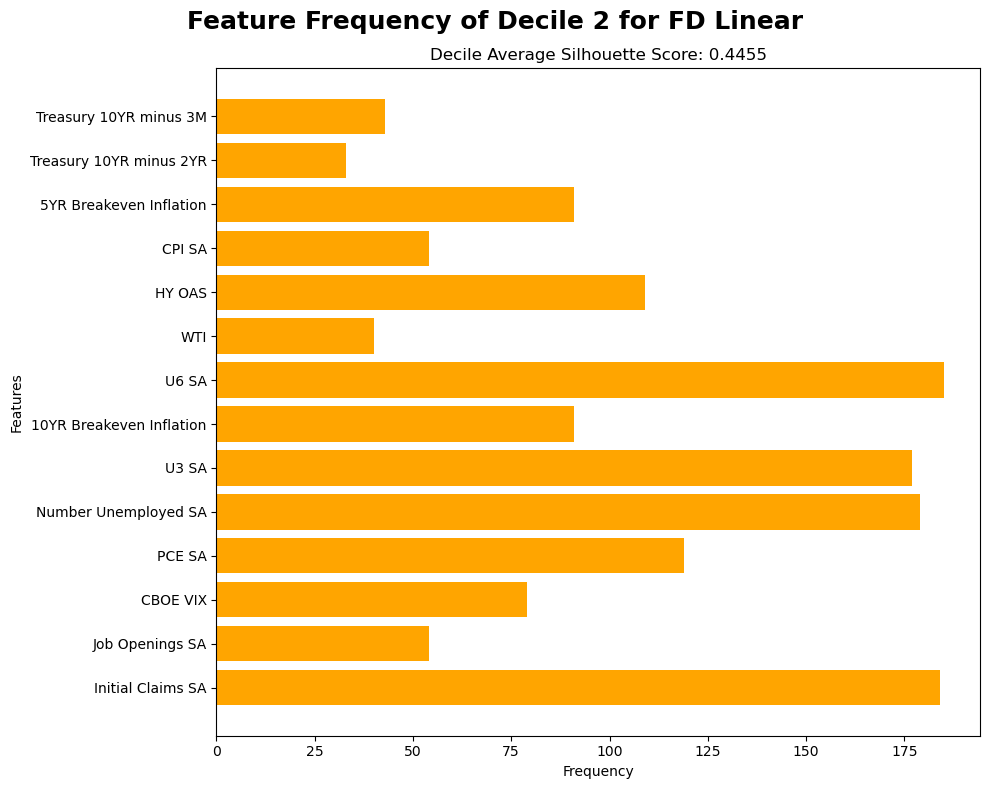

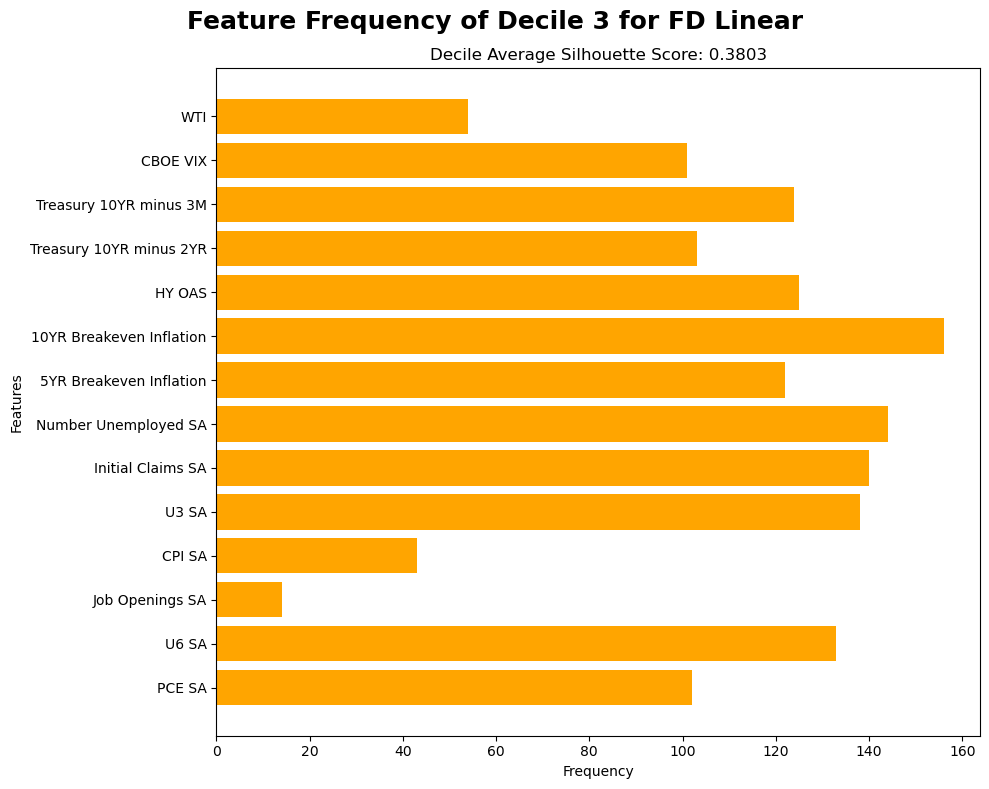

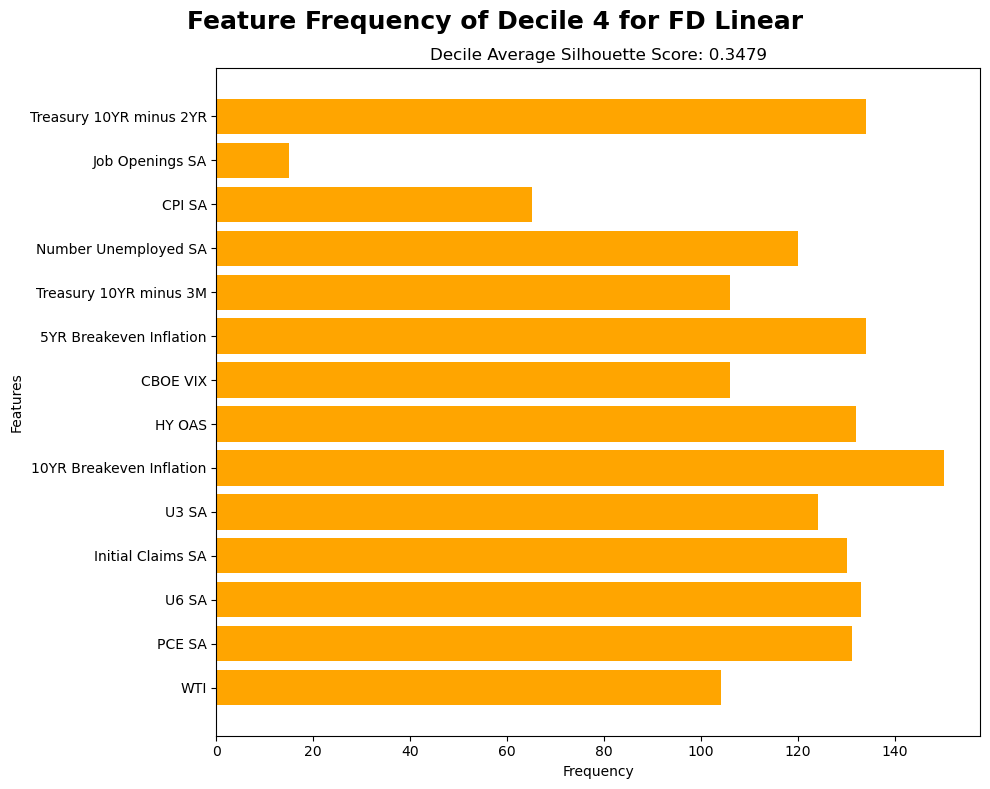

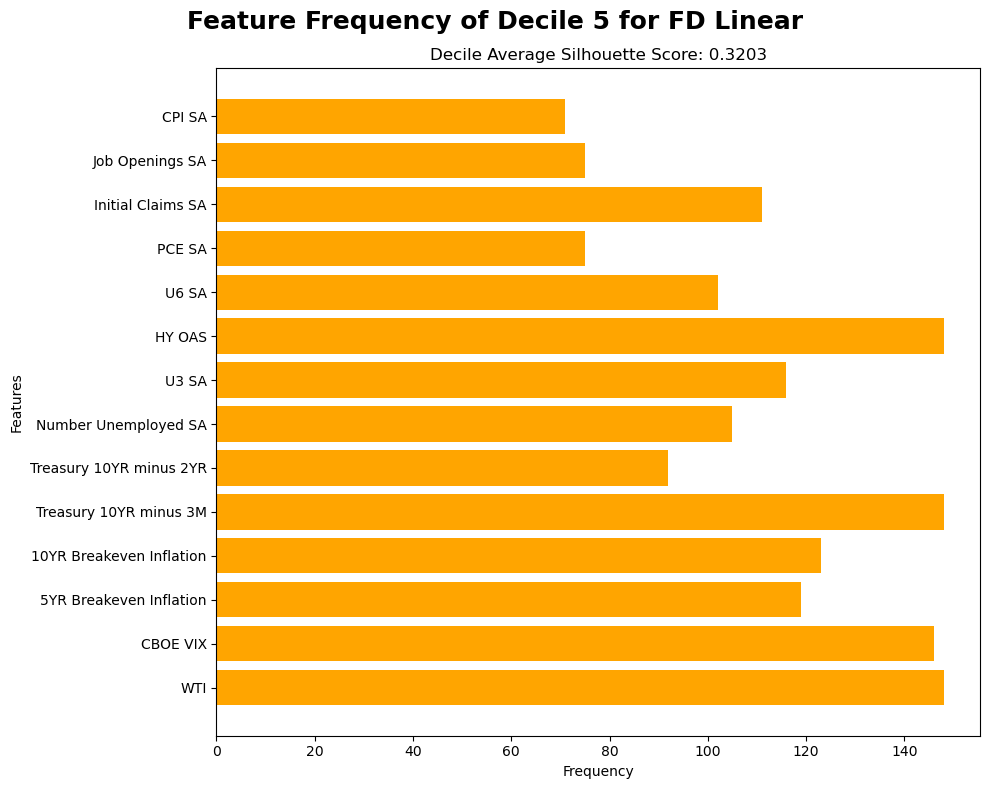

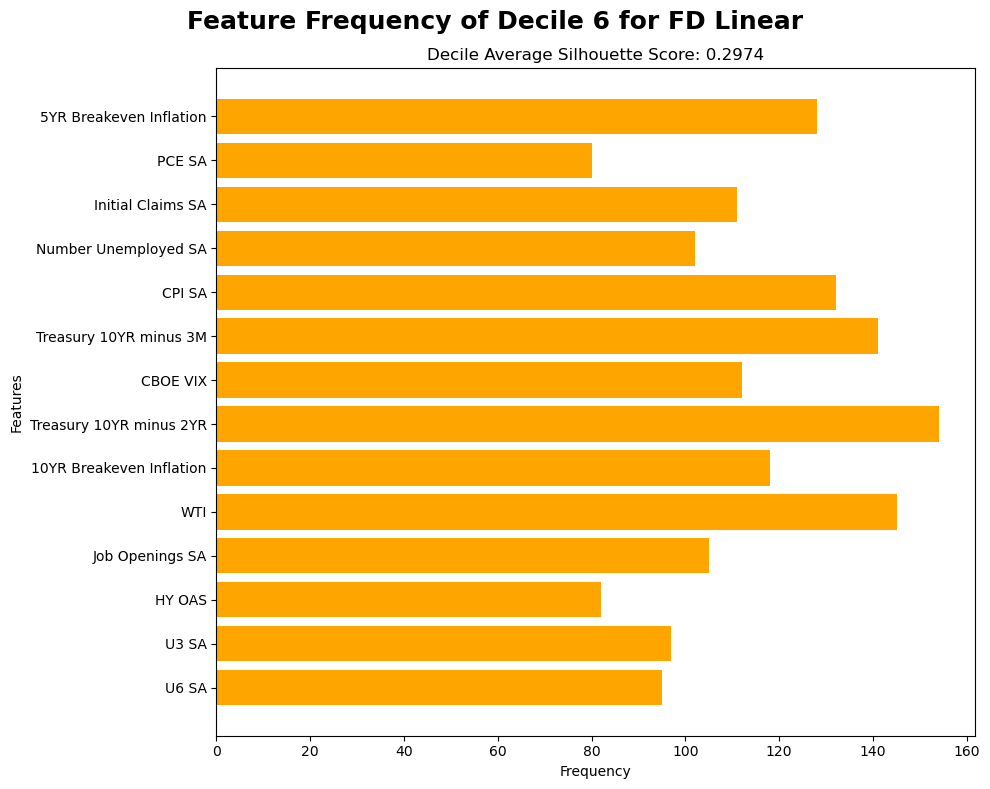

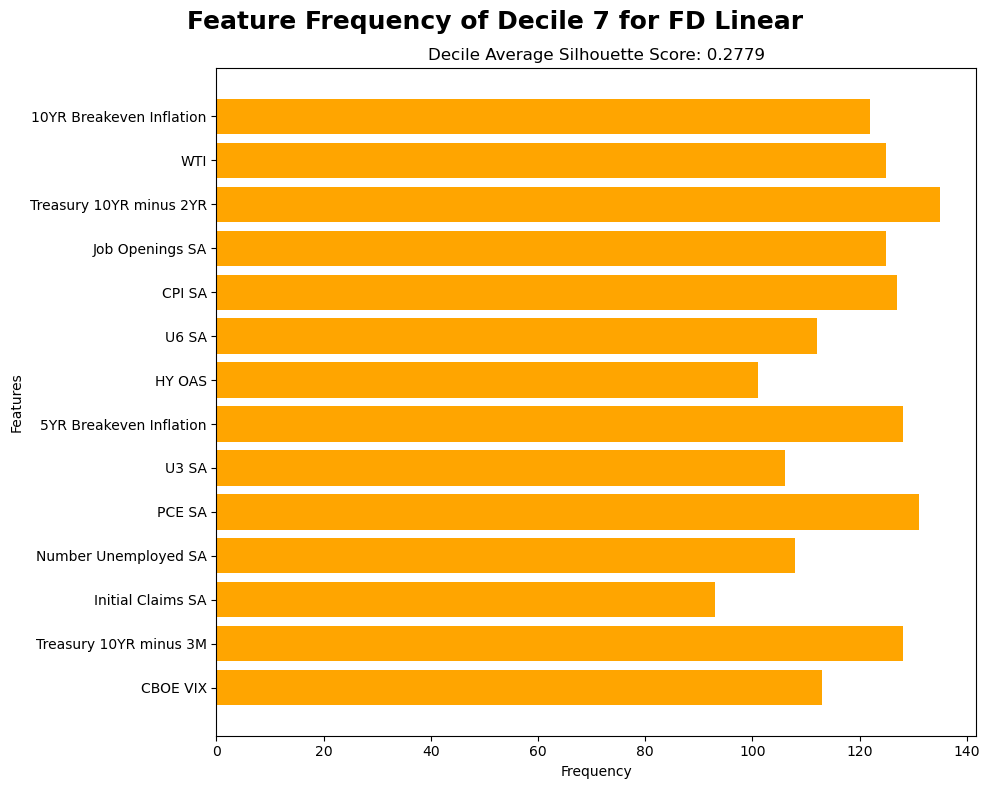

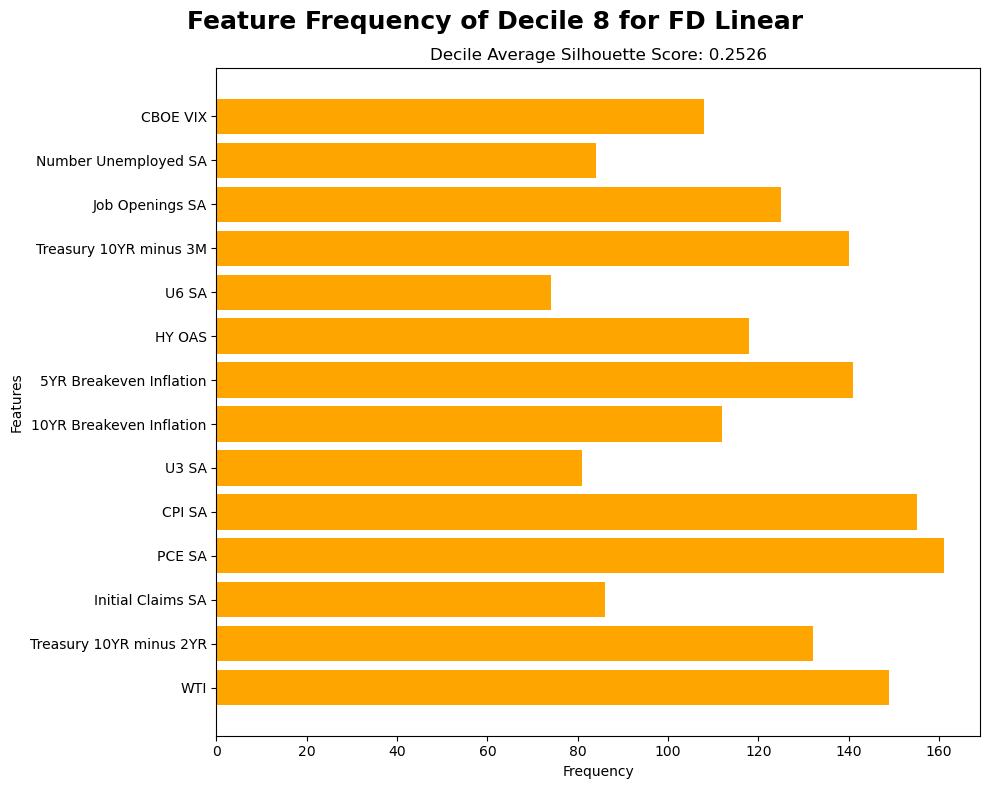

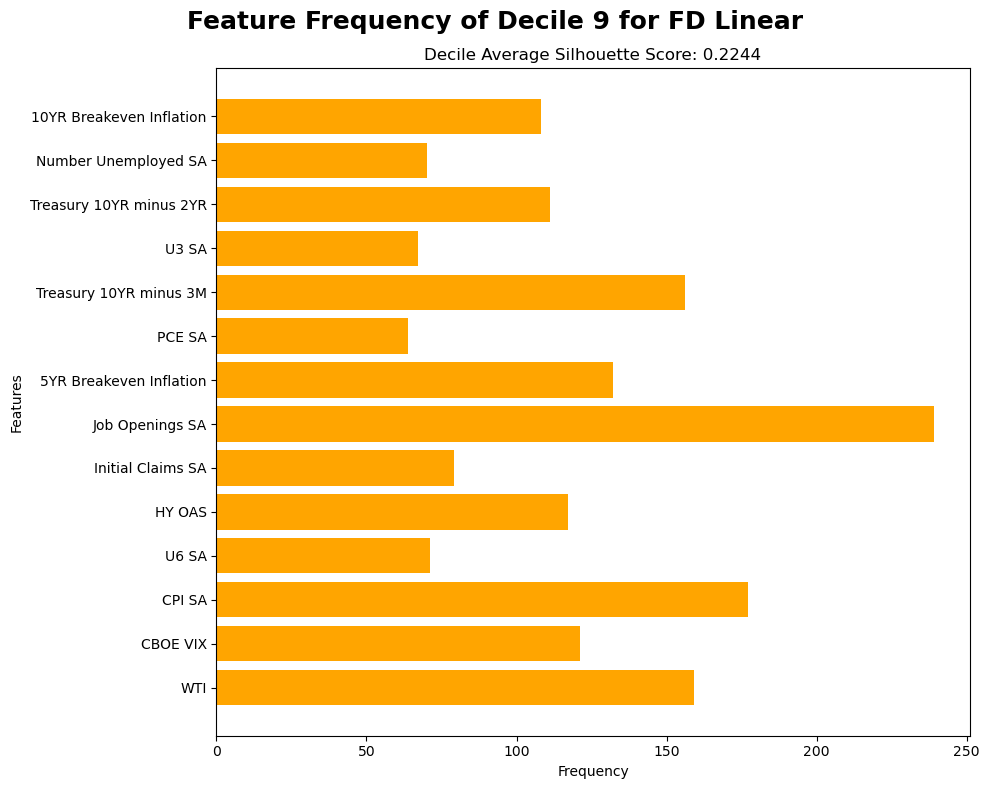

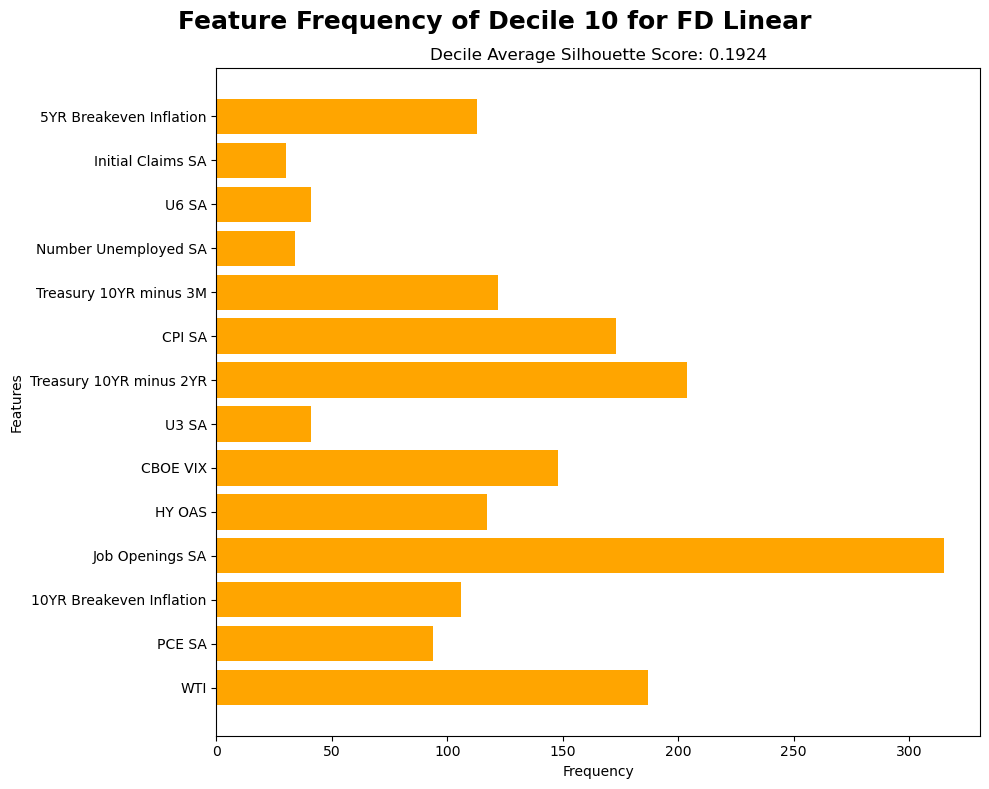

In [254]:
# Fractionally Differenced Linear Imputed Data

fd_linear_stats_dict = all_model_stats_percentile_dict['fd_linear']

for decile_key, stats_dict in fd_linear_stats_dict.items():
    decile_num = int(decile_key) + 1
    plot_feature_frequency(decile_num, stats_dict, 'FD Linear', color='orange')

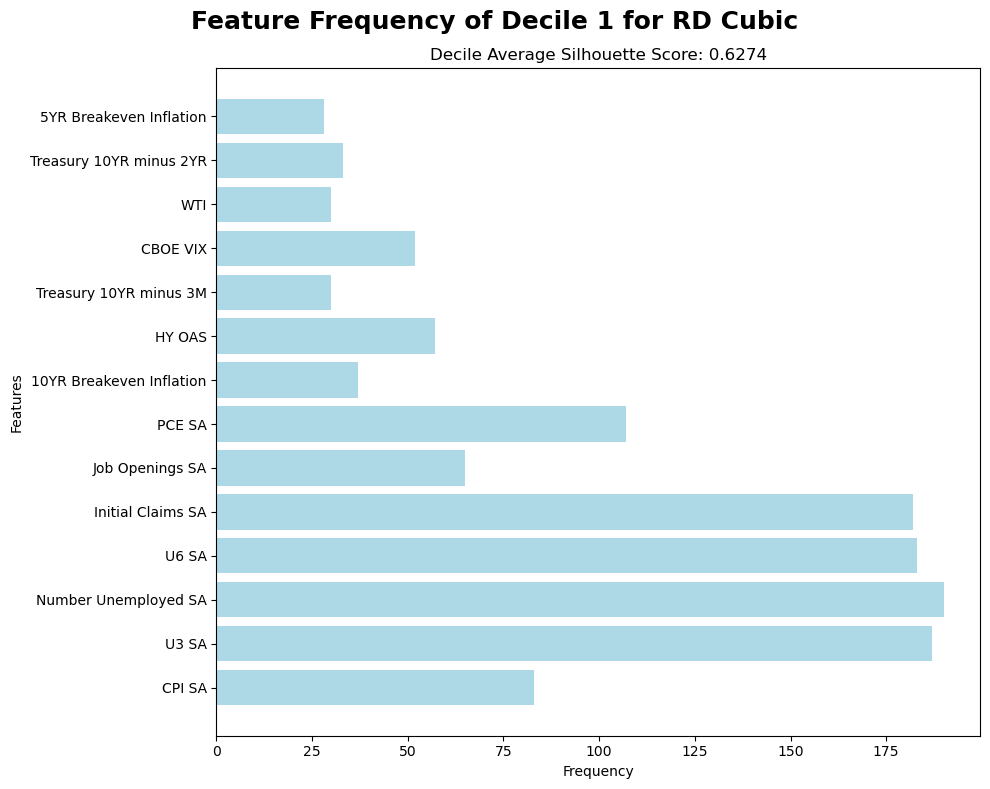

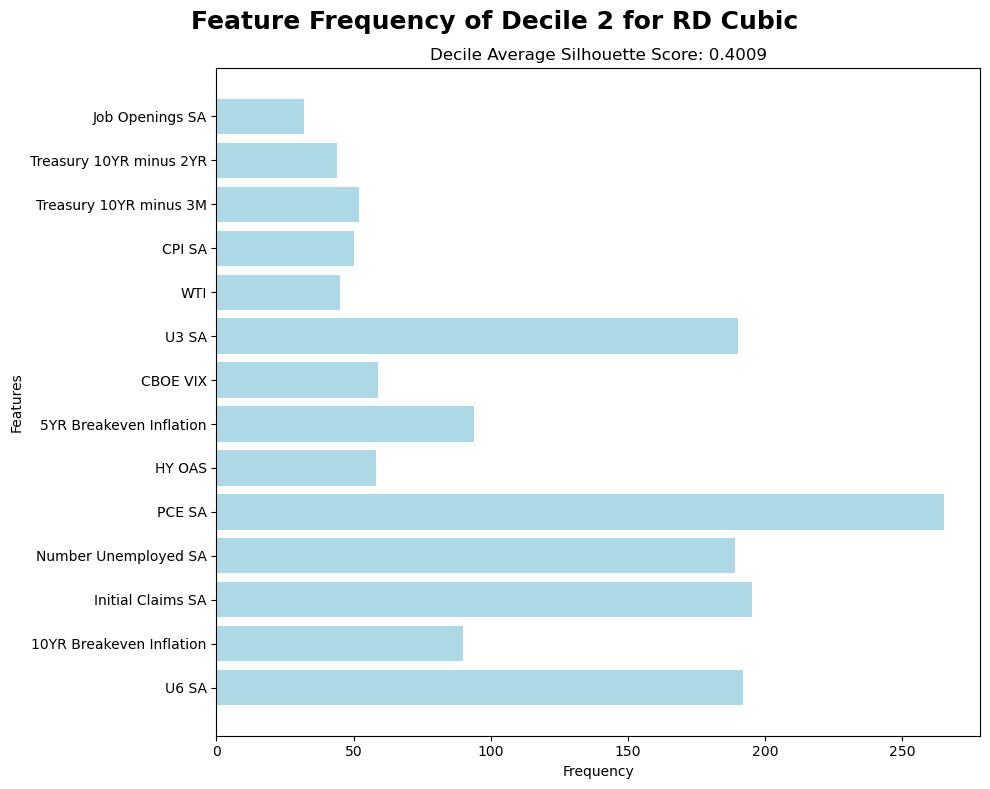

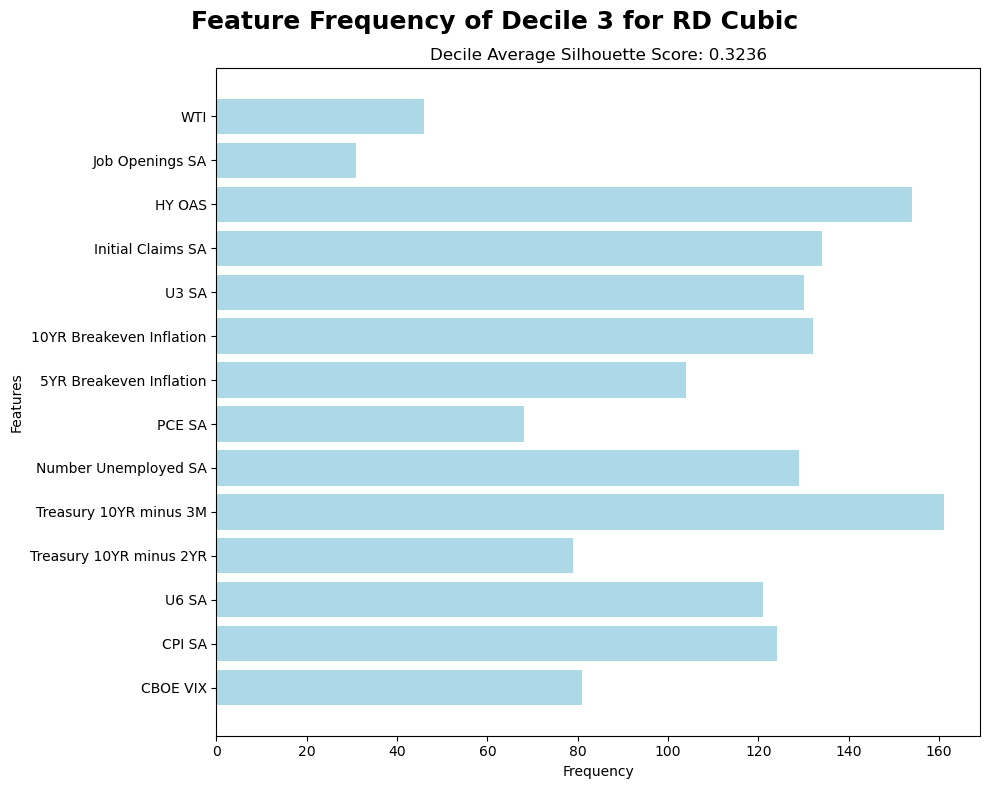

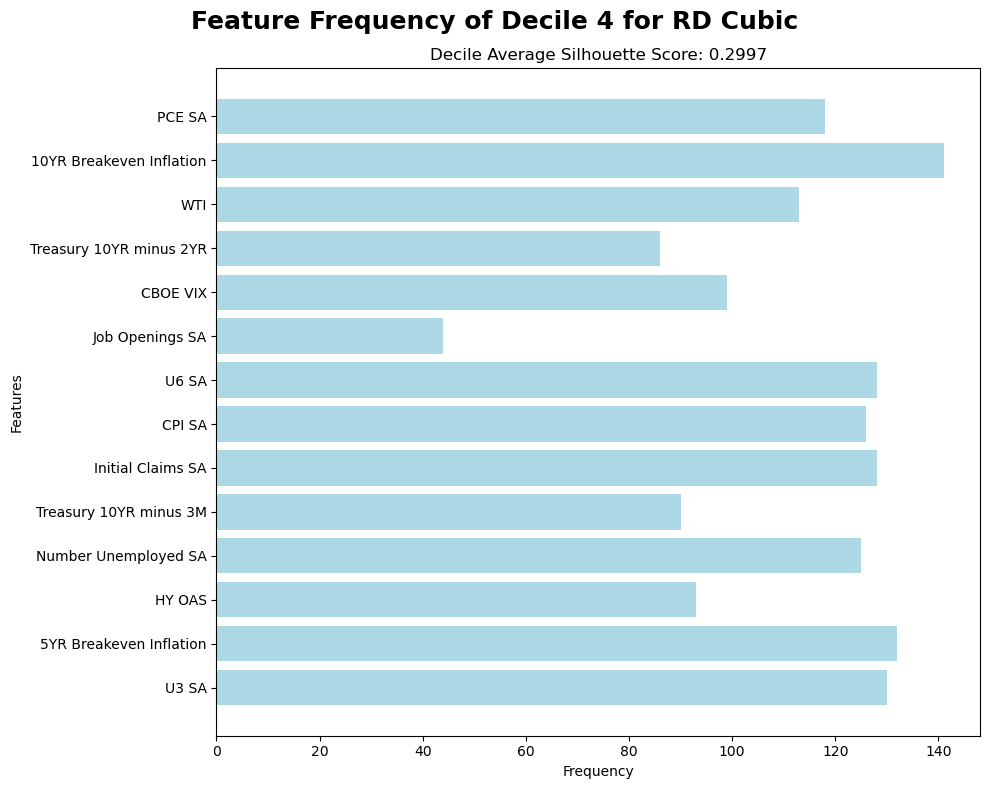

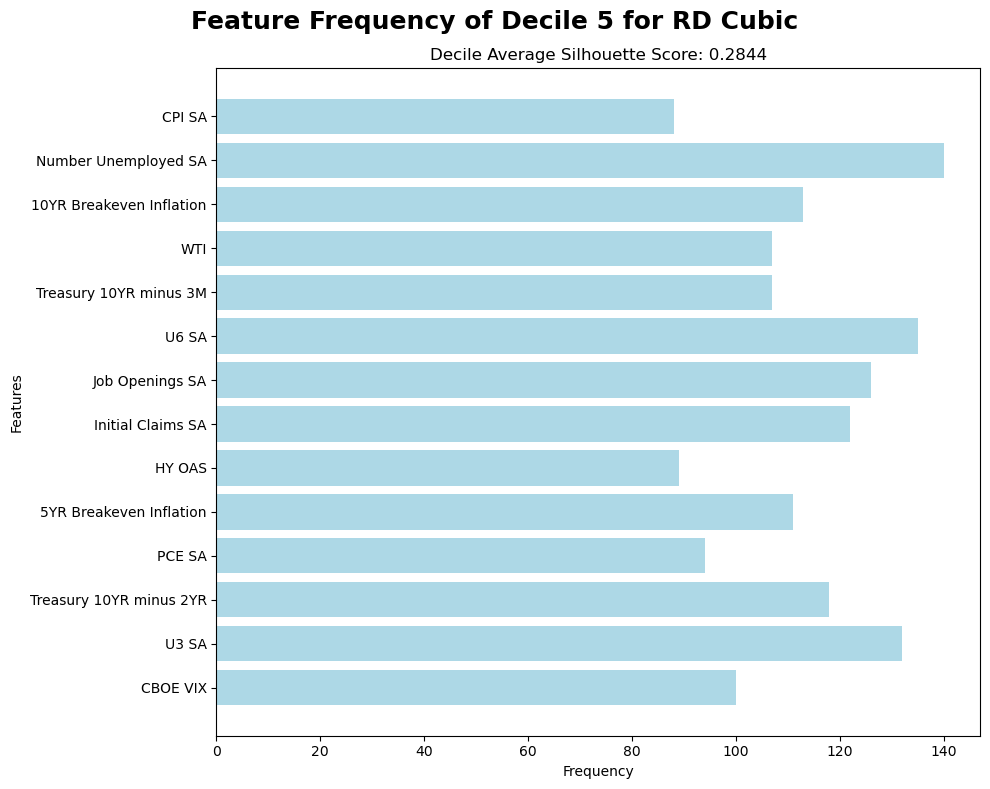

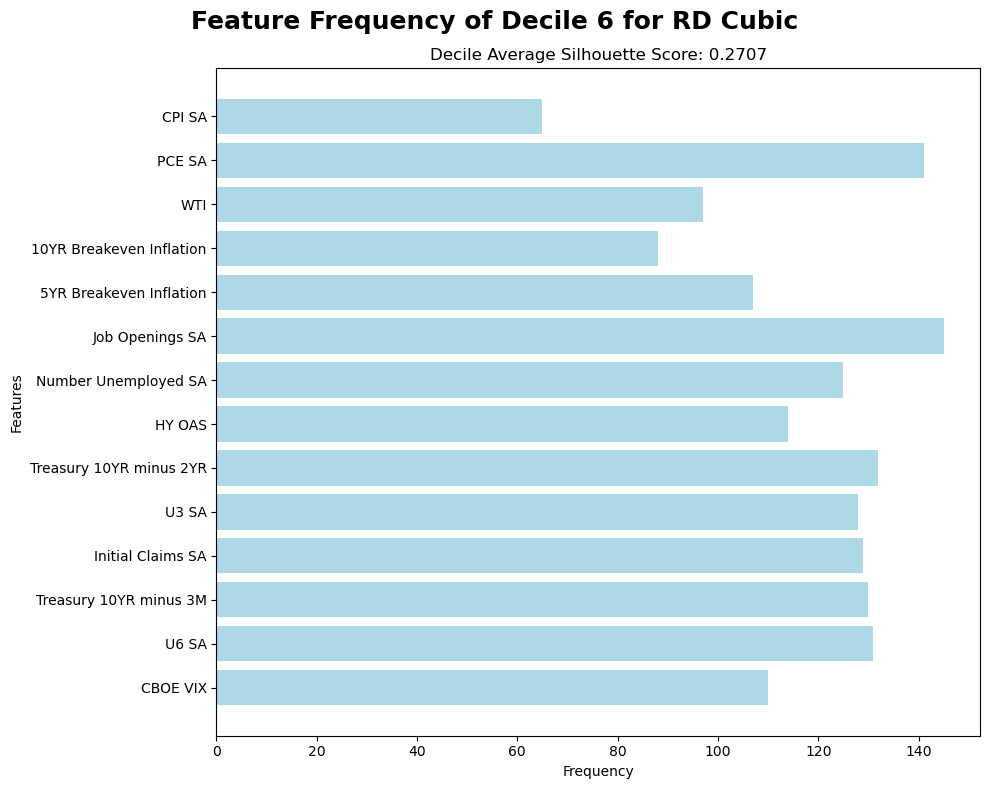

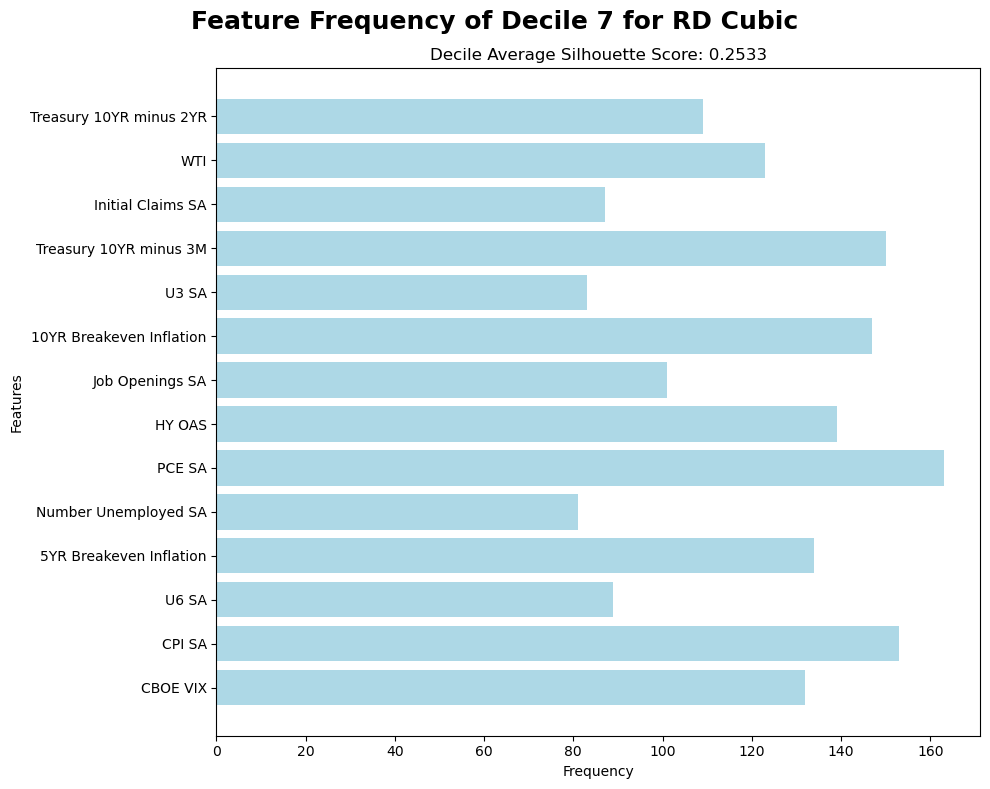

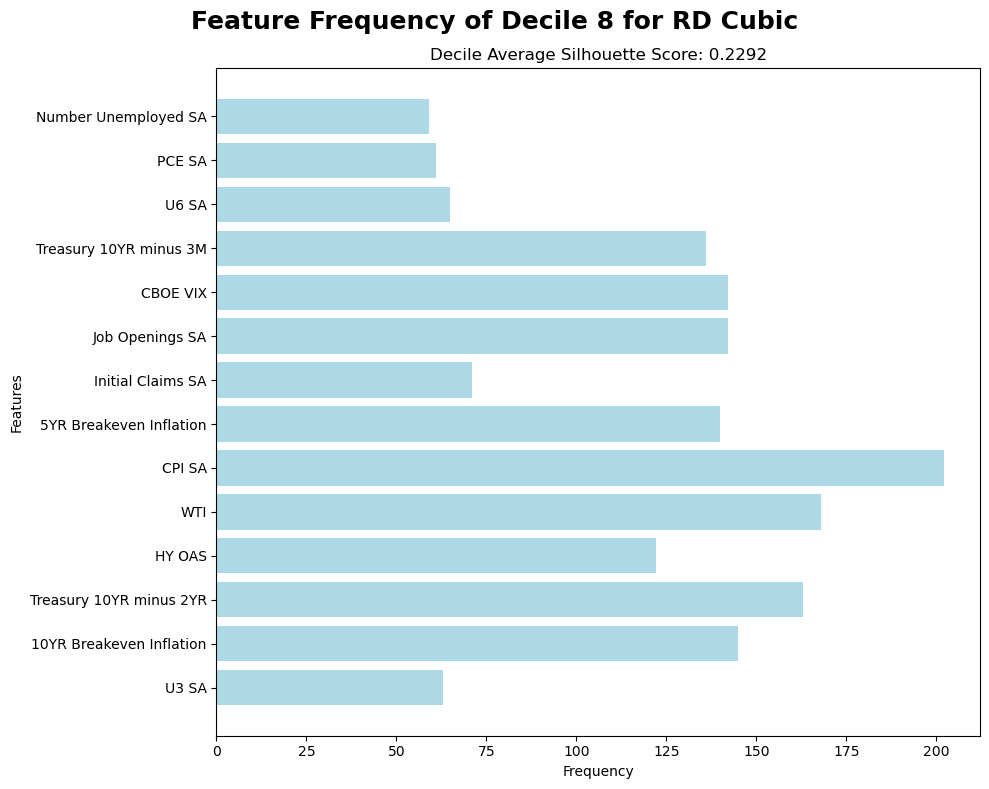

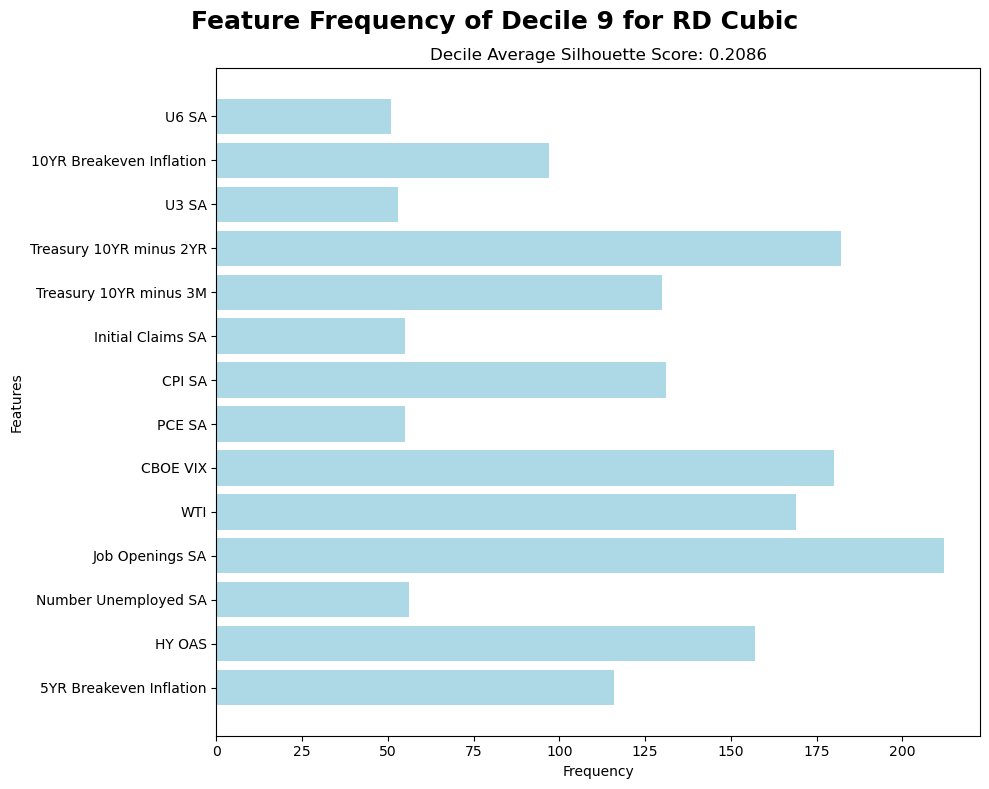

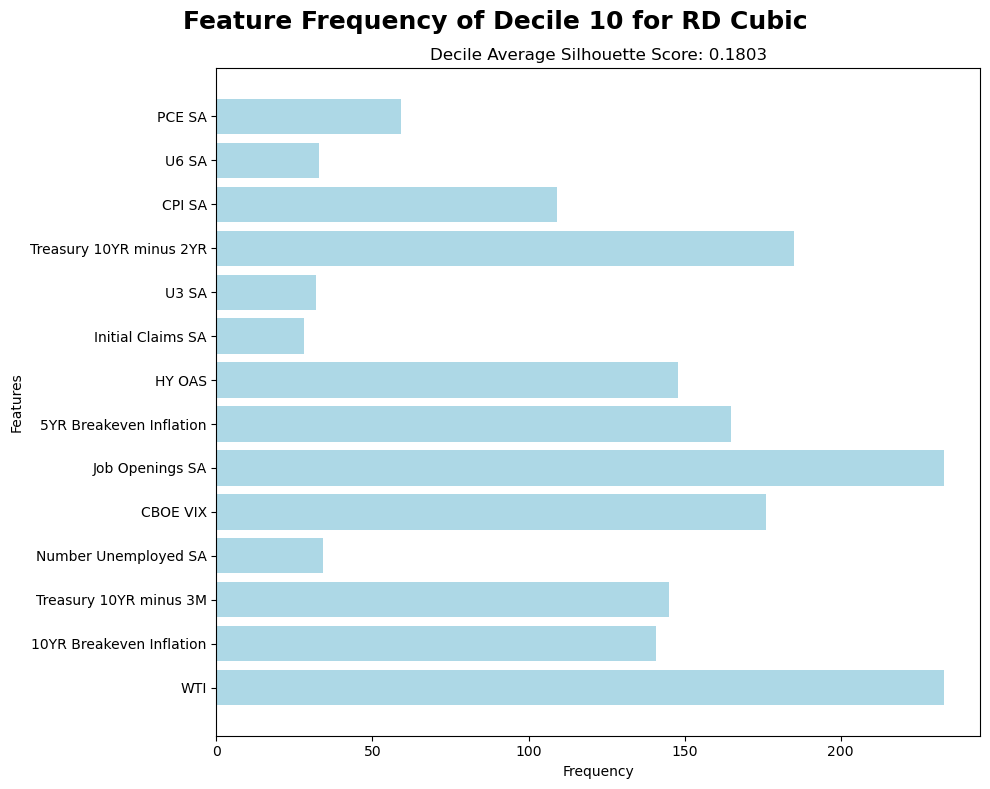

In [255]:
# Regularly Differenced Cubic Imputed Data

rd_cubic_stats_dict = all_model_stats_percentile_dict['rd_cubic']

for decile_key, stats_dict in rd_cubic_stats_dict.items():
    decile_num = int(decile_key) + 1
    plot_feature_frequency(decile_num, stats_dict, 'RD Cubic', color='lightblue')

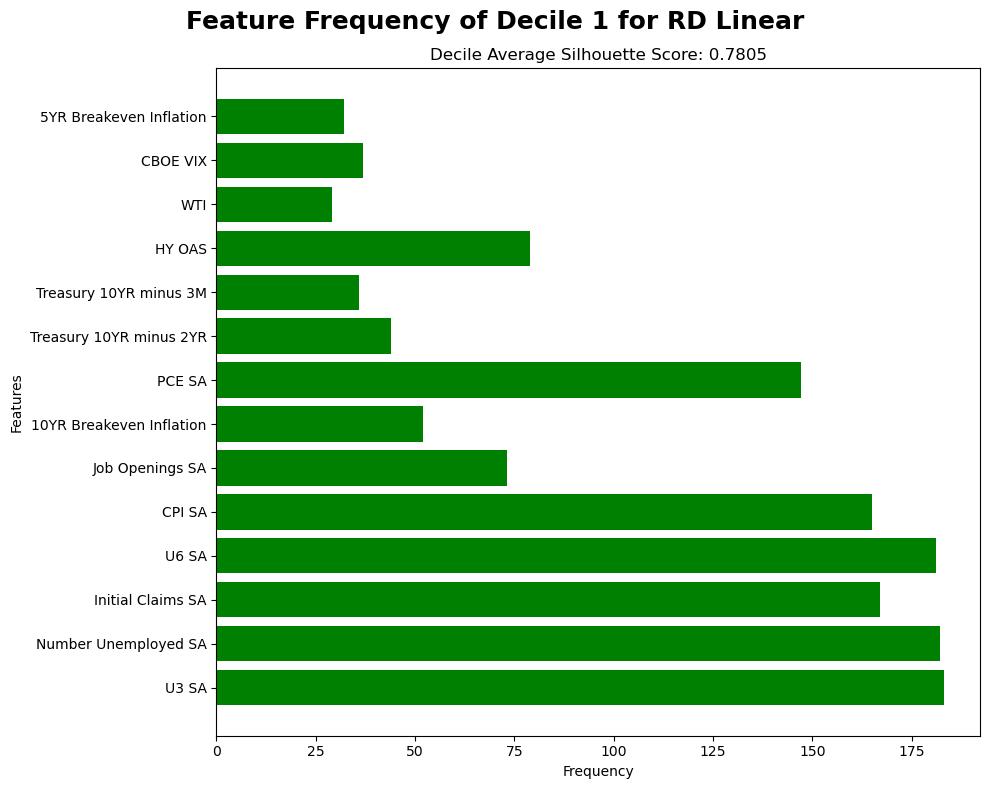

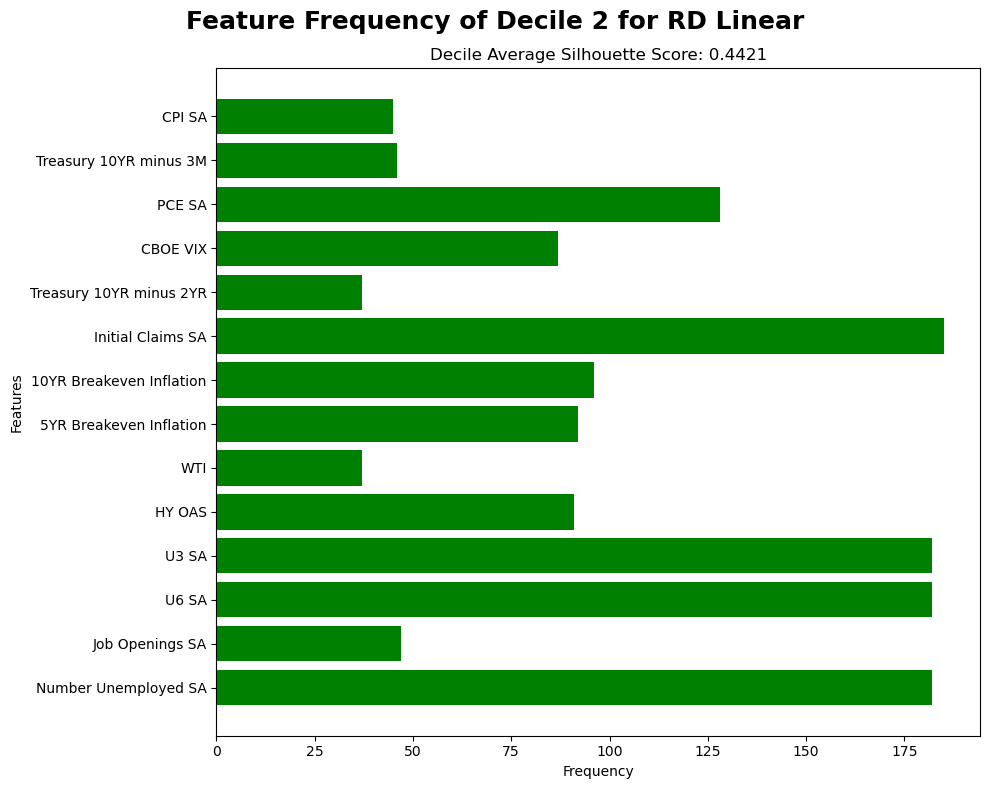

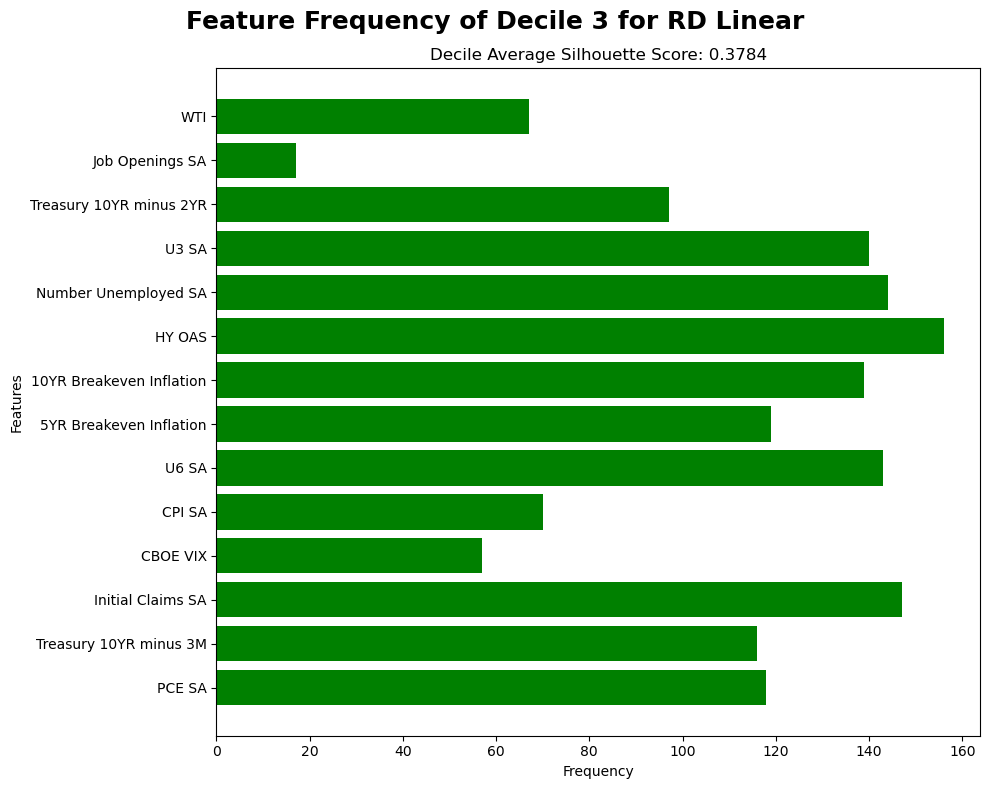

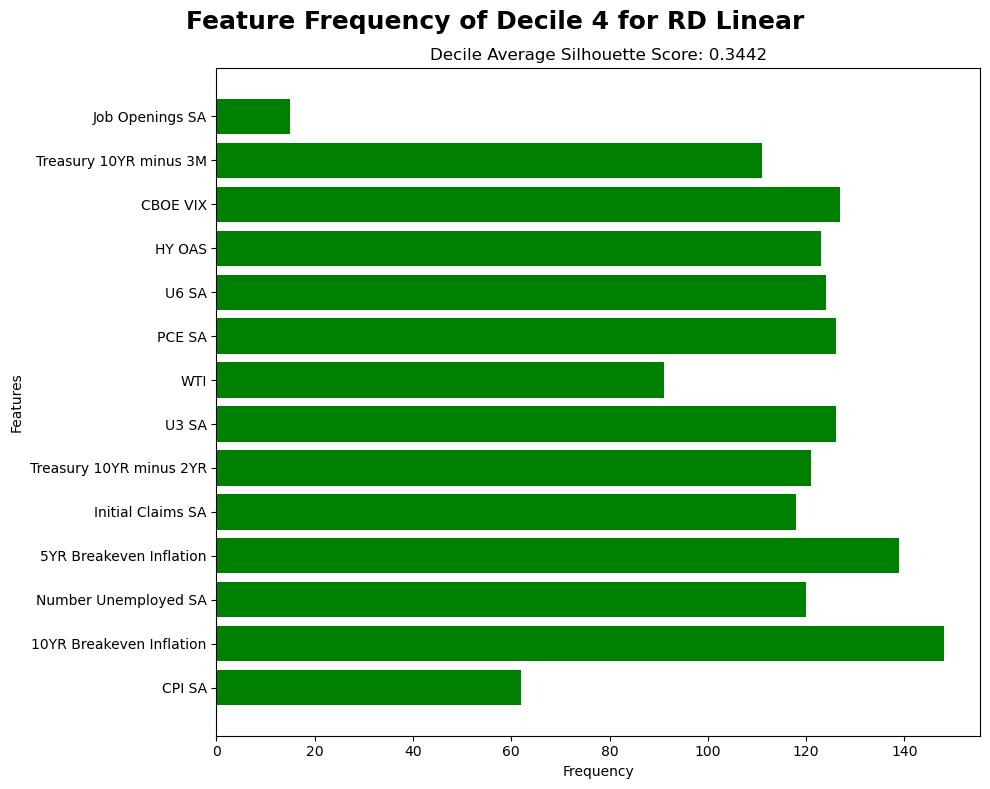

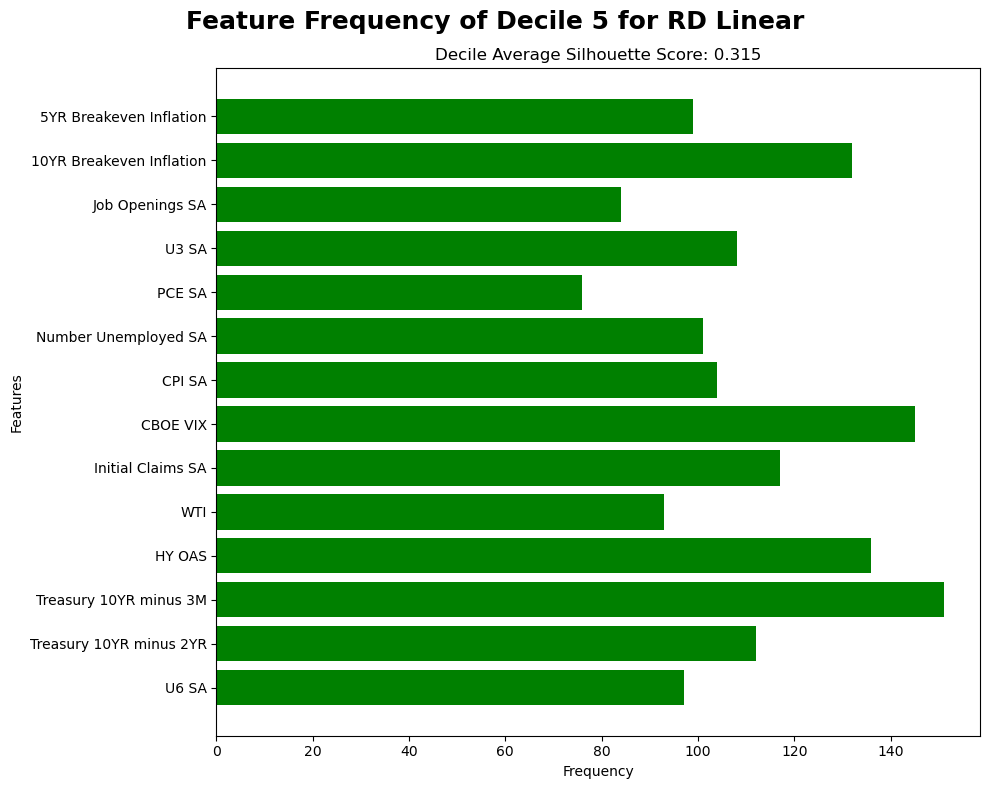

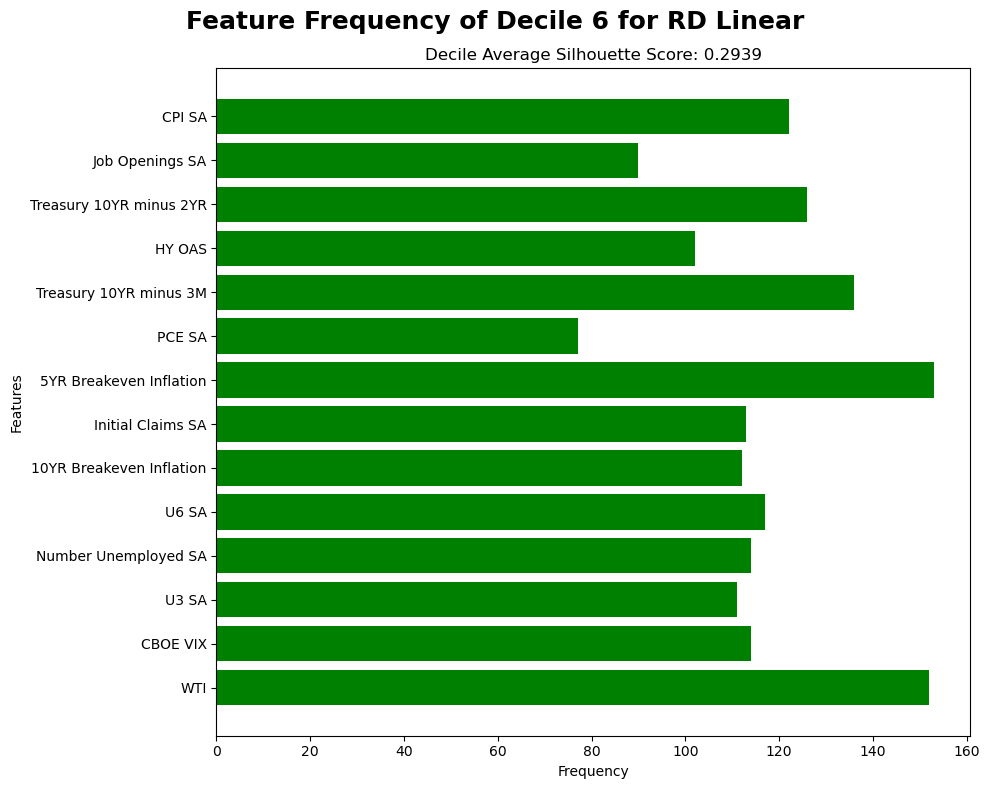

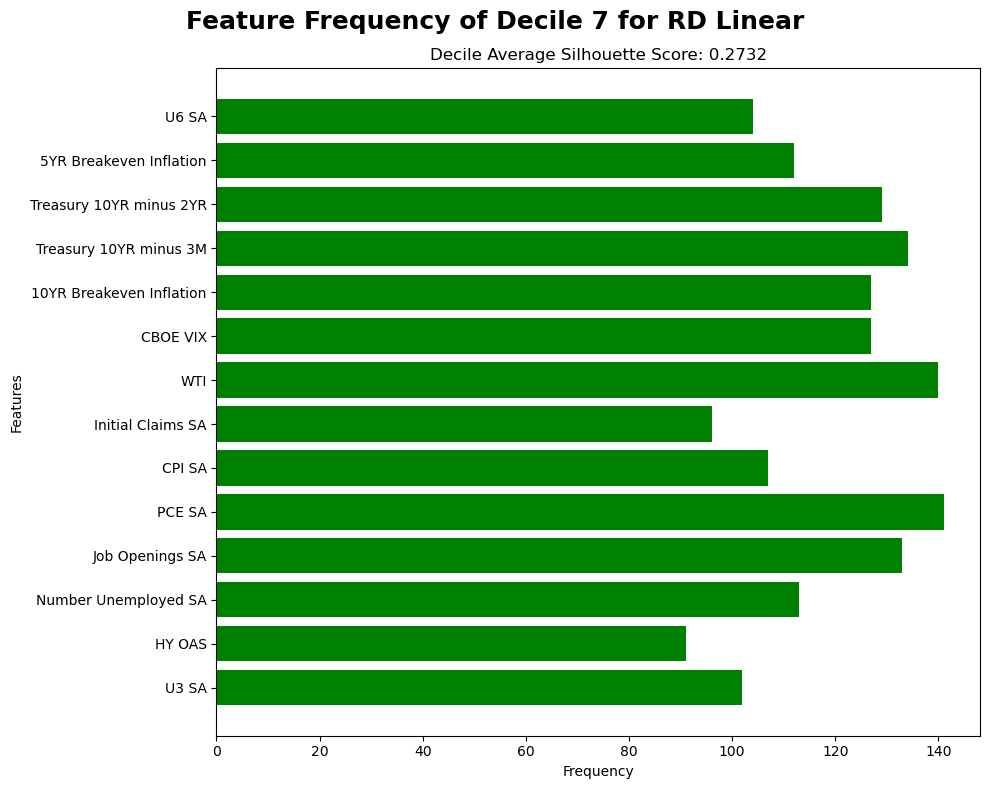

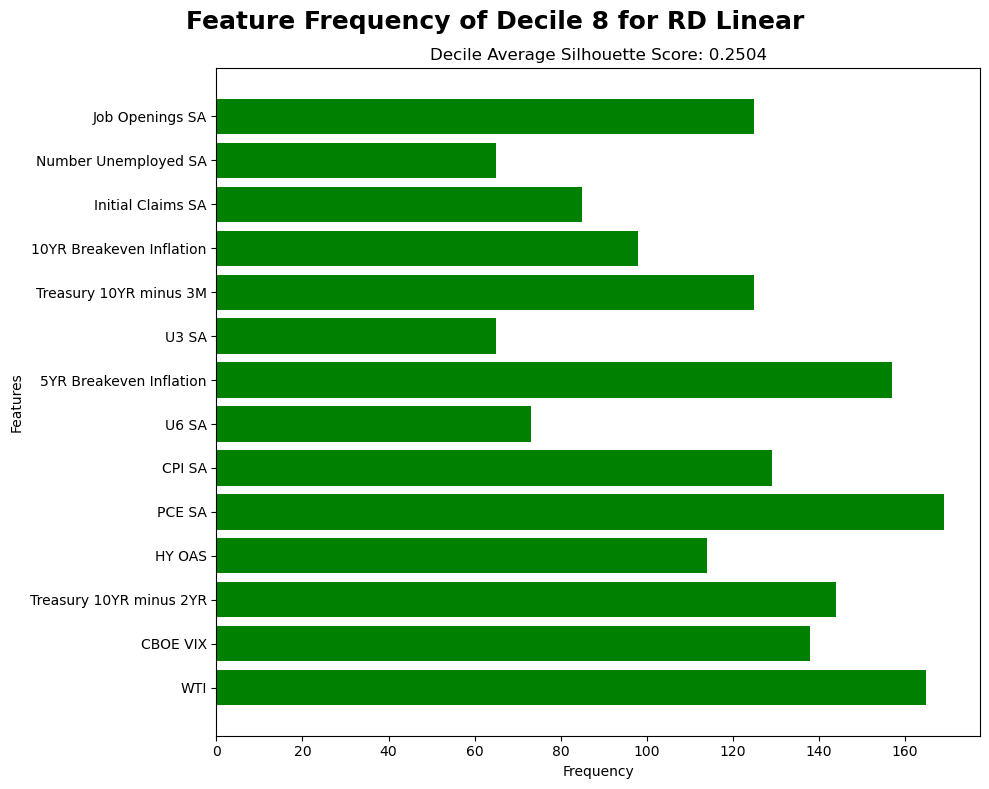

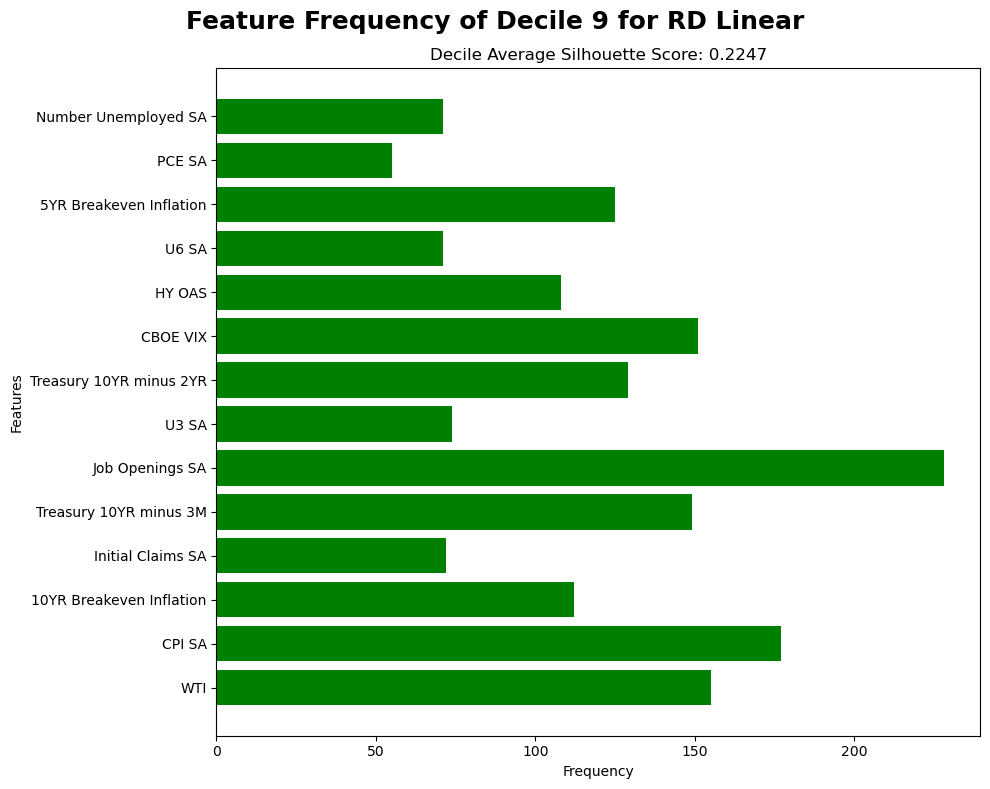

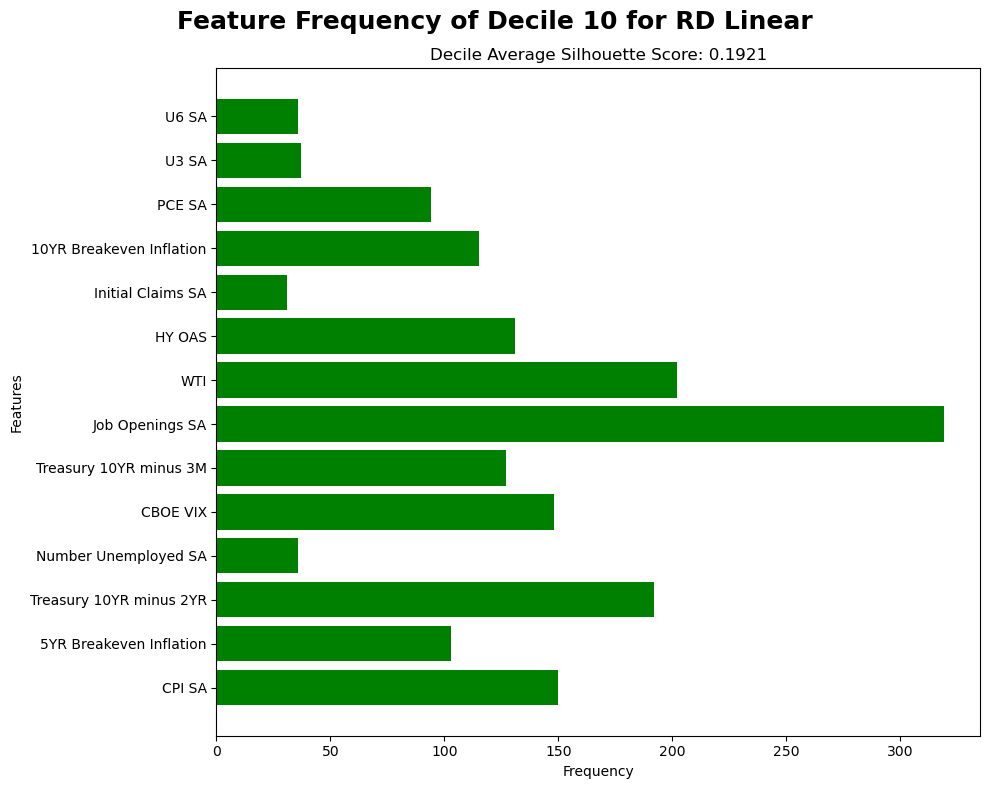

In [256]:
# Regularly Differenced Linear Imputed Data

rd_cubic_stats_dict = all_model_stats_percentile_dict['rd_linear']

for decile_key, stats_dict in rd_cubic_stats_dict.items():
    decile_num = int(decile_key) + 1
    plot_feature_frequency(decile_num, stats_dict, 'RD Linear', color='green')

In [ ]:
# Find optimal combination of economic features for data frames

numeric_cols = [
    'WTI', 'CBOE VIX', 'PCE SA', 'CPI SA', 'U6 SA', 'U3 SA', 'HY OAS',
    'Initial Claims SA', 'Number Unemployed SA', 'Job Openings SA'
]

fd_cs_heap = []
fd_lin_heap = []
rd_cs_heap = []
rd_lin_heap = []

total_combinations = sum(len(list(itertools.combinations(numeric_cols, i))) for i in range(5, len(numeric_cols)+1))
processed = 0

print(f"Processing {total_combinations} feature combinations...")

for i in range(5, len(numeric_cols)+1):
    print(f"Testing combinations of {i} features...")
    
    for col_combo in itertools.combinations(numeric_cols, i):
        processed += 1
        print(f"Working on combination {processed}")
        
        for k in range(3, 6):
            try:
                scaler_fd_cs = StandardScaler()
                scaler_fd_lin = StandardScaler()
                scaler_rd_cs = StandardScaler()
                scaler_rd_lin = StandardScaler()
                
                fd_cs_features_scaled = scaler_fd_cs.fit_transform(fd_cs_df[list(col_combo)].dropna())
                fd_lin_features_scaled = scaler_fd_lin.fit_transform(fd_lin_df[list(col_combo)].dropna())
                rd_cs_features_scaled = scaler_rd_cs.fit_transform(rd_cs_df[list(col_combo)].dropna())
                rd_lin_features_scaled = scaler_rd_lin.fit_transform(rd_lin_df[list(col_combo)].dropna())
                
                if (len(fd_cs_features_scaled) < k or len(fd_lin_features_scaled) < k or 
                    len(rd_cs_features_scaled) < k or len(rd_lin_features_scaled) < k):
                    continue
                
                kmeans_fd_cs = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
                kmeans_fd_lin = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
                kmeans_rd_cs = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
                kmeans_rd_lin = KMeans(n_clusters=k, random_state=42, n_init=10, max_iter=300)
                
                fd_cs_labels = kmeans_fd_cs.fit_predict(fd_cs_features_scaled)
                fd_lin_labels = kmeans_fd_lin.fit_predict(fd_lin_features_scaled)
                rd_cs_labels = kmeans_rd_cs.fit_predict(rd_cs_features_scaled)
                rd_lin_labels = kmeans_rd_lin.fit_predict(rd_lin_features_scaled)
                
                fd_cs_silhouette = silhouette_score(fd_cs_features_scaled, fd_cs_labels)
                fd_lin_silhouette = silhouette_score(fd_lin_features_scaled, fd_lin_labels)
                rd_cs_silhouette = silhouette_score(rd_cs_features_scaled, rd_cs_labels)
                rd_lin_silhouette = silhouette_score(rd_lin_features_scaled, rd_lin_labels)
                
                 # Negative for max heap like structure
                heapq.heappush(fd_cs_heap, (-fd_cs_silhouette, col_combo, k, len(col_combo)))
                heapq.heappush(fd_lin_heap, (-fd_lin_silhouette, col_combo, k, len(col_combo)))
                heapq.heappush(rd_cs_heap, (-rd_cs_silhouette, col_combo, k, len(col_combo)))
                heapq.heappush(rd_lin_heap, (-rd_lin_silhouette, col_combo, k, len(col_combo)))
                
            except Exception as e:
                continue

In [ ]:
# Downloading maxheaps (maxheaps are downloaded because, the prior cell takes a long-time to run)

import pickle

maxheap_dict = {
    "fd_cubic": fd_cs_heap,
    "fd_linear": fd_lin_heap,
    "rd_cubic": rd_cs_heap,
    "rd_linear": rd_lin_heap
}

base_path = "/Users/henrycosentino/Desktop/Python/Projects/State Dependent CVaR & VaR/data"

for key, heap in maxheap_dict.items():
    try:
        filename = f"{base_path}/{key}_maxheap_(5-10_feature_combos).pkl"
        with open(filename, 'wb') as f:
            pickle.dump(heap, f)
    except Exception as e:
        print(f"Error saving {key}: {e}")

In [259]:
# Load in the (above downloaded) data

maxheaps_dict2 = {}

base_path = "/Users/henrycosentino/Desktop/Python/Projects/State Dependent CVaR & VaR/data"
heap_keys = ["fd_cubic", "fd_linear", "rd_cubic", "rd_linear"]

for key in heap_keys:
    filename = f"{base_path}/{key}_maxheap_(5-10_feature_combos).pkl"
    with open(filename, 'rb') as f:
        maxheaps_dict2[key] = pickle.load(f)

In [260]:
# Display top 5 combos for each data set

for key in heap_keys:
    heap = maxheaps_dict2[key]
    print("----"*20)
    print(f"Top five combos for {key.replace('_', ' ')}")

    top_5 = heapq.nsmallest(5, heap)
    
    for i, combo_stats in enumerate(top_5, 1):
        combo = combo_stats[1]
        score = -round(combo_stats[0], 4)

        print(f"#{i}: \n  Combo: {combo}\n  Score: {score}")

--------------------------------------------------------------------------------
Top five combos for fd cubic
#1: 
  Combo: ('PCE SA', 'CPI SA', 'U6 SA', 'Initial Claims SA', 'Number Unemployed SA', 'Job Openings SA')
  Score: 0.9675
#2: 
  Combo: ('CBOE VIX', 'CPI SA', 'U6 SA', 'U3 SA', 'Number Unemployed SA', 'Job Openings SA')
  Score: 0.9619
#3: 
  Combo: ('PCE SA', 'U6 SA', 'U3 SA', 'Initial Claims SA', 'Number Unemployed SA')
  Score: 0.9617
#4: 
  Combo: ('CBOE VIX', 'CPI SA', 'U6 SA', 'U3 SA', 'Initial Claims SA', 'Job Openings SA')
  Score: 0.9603
#5: 
  Combo: ('CBOE VIX', 'CPI SA', 'U6 SA', 'Initial Claims SA', 'Number Unemployed SA', 'Job Openings SA')
  Score: 0.9602
--------------------------------------------------------------------------------
Top five combos for fd linear
#1: 
  Combo: ('CPI SA', 'U6 SA', 'U3 SA', 'Initial Claims SA', 'Job Openings SA')
  Score: 0.9709
#2: 
  Combo: ('CPI SA', 'U3 SA', 'Initial Claims SA', 'Number Unemployed SA', 'Job Openings SA')
  S

In [261]:
# K Means for Fractionally Differenced Cubic Imputed Data Frame

score, feature_names, k, feature_count = heapq.heappop(maxheaps_dict2['fd_cubic'])
opt_fd_cs_df = fd_cs_df[list(feature_names)].copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(opt_fd_cs_df)

kmeans = KMeans(n_clusters=int(k), random_state=42, n_init=10, max_iter=300)
opt_fd_cs_df['state'] = kmeans.fit_predict(scaled_data)

opt_fd_cs_df.head()

,PCE SA,CPI SA,U6 SA,Initial Claims SA,Number Unemployed SA,Job Openings SA,state
date,,,,,,,
2003-01-03,-2.149639,0.033189,0.021583,-3112.027865,12.280607,-6.943261,0
2003-01-04,-1.927978,0.033456,0.020131,-3368.401604,11.374305,-6.969405,0
2003-01-06,-3.212901,0.067569,0.036062,-7010.421621,20.138680,-14.002874,0
2003-01-07,-1.295887,0.034042,0.016011,-3180.199934,8.818862,-7.026285,0
2003-01-08,-1.096154,0.034166,0.014717,-2635.258466,8.021534,-7.038060,0


In [262]:
# K Means for Fractionally Differenced Linear Imputed Data Frame

score, feature_names, k, feature_count = heapq.heappop(maxheaps_dict2['fd_linear'])
opt_fd_lin_df = fd_lin_df[list(feature_names)].copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(opt_fd_lin_df)

kmeans = KMeans(n_clusters=int(k), random_state=42, n_init=10, max_iter=300)
opt_fd_lin_df['state'] = kmeans.fit_predict(scaled_data)

opt_fd_lin_df.head()

,CPI SA,U6 SA,U3 SA,Initial Claims SA,Job Openings SA,state
date,,,,,,
2003-01-03,0.037037,0.007407,0.003704,-2666.666667,-7.851852,0
2003-01-04,0.037037,0.007407,0.003704,-2666.666667,-7.851852,0
2003-01-06,0.037037,0.007407,0.003704,-2500.000000,-7.851852,0
2003-01-07,0.037037,0.007407,0.003704,-2500.000000,-7.851852,0
2003-01-08,0.037037,0.007407,0.003704,-2500.000000,-7.851852,0


In [263]:
# K Means for Regularly Differenced Cubic Imputed Data Frame

score, feature_names, k, feature_count = heapq.heappop(maxheaps_dict2['rd_cubic'])
opt_rd_cs_df = rd_cs_df[list(feature_names)].copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(opt_rd_cs_df)

kmeans = KMeans(n_clusters=int(k), random_state=42, n_init=10, max_iter=300)
opt_rd_cs_df['state'] = kmeans.fit_predict(scaled_data)

opt_rd_cs_df.head()

,CPI SA,U6 SA,Initial Claims SA,Number Unemployed SA,Job Openings SA,state
date,,,,,,
2003-01-03,0.000182,0.021583,-3112.027865,12.280607,-6.943261,0
2003-01-04,0.000183,0.020131,-3368.401604,11.374305,-6.969405,0
2003-01-06,0.000370,0.036062,-7010.421621,20.138680,-14.002874,0
2003-01-07,0.000186,0.016011,-3180.199934,8.818862,-7.026285,0
2003-01-08,0.000187,0.014717,-2635.258466,8.021534,-7.038060,0


In [264]:
# K Means for Regularly Differenced Cubic Imputed Data Frame

score, feature_names, k, feature_count = heapq.heappop(maxheaps_dict2['rd_linear'])
opt_rd_lin_df = rd_lin_df[list(feature_names)].copy()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(opt_rd_lin_df)

kmeans = KMeans(n_clusters=int(k), random_state=42, n_init=10, max_iter=300)
opt_rd_lin_df['state'] = kmeans.fit_predict(scaled_data)

opt_rd_lin_df.head()

,CPI SA,U6 SA,U3 SA,Number Unemployed SA,Job Openings SA,state
date,,,,,,
2003-01-03,0.000203,0.007407,0.003704,3.62963,-7.851852,0
2003-01-04,0.000203,0.007407,0.003704,3.62963,-7.851852,0
2003-01-06,0.000203,0.007407,0.003704,3.62963,-7.851852,0
2003-01-07,0.000203,0.007407,0.003704,3.62963,-7.851852,0
2003-01-08,0.000203,0.007407,0.003704,3.62963,-7.851852,0
